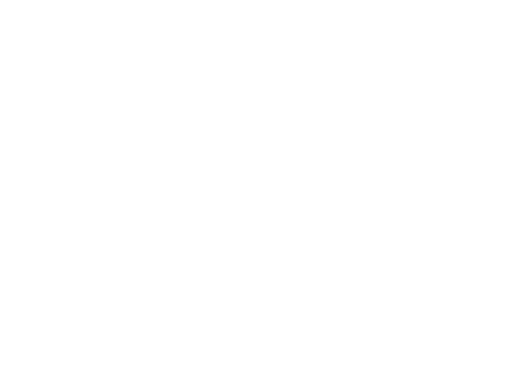

In [2]:


import os
import re
import sys
import gzip
import time
import math
import copy
import numpy
import pandas
import seaborn
import matplotlib

import numpy as np

import scipy.stats
import matplotlib.pyplot as plt


from scipy.ndimage import gaussian_filter

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA


# seaborn.set()
matplotlib.style.use('default')
plt.axis('off')


bs_color = "#0d1780"
mg_color = "#f0aa4f"

samples = ["HG00621", "HG00741", "HG01952", "HG01978", "HG03516"]
replicates = [1, 2]
phases = ["mat", "pat"]


min_cov = 5





In [ ]:
"""
What figures are needed?

Figure 1: Pass (Workflow)

Figure 2: Benchmark
2A Runtime
2B Peak memory
2C Read fate 

Figure 3:
3A 1D-density for methylation
3B CpG count
3C Coverage distribution


Figure 4:
4A Bismark rep1 vs rep2 (TODO)
4B methylGrapher rep1 vs rep2 (TODO)
4C Bismark sample1 vs sample2 (TODO)
4D Delta methylation (TODO)
4E PCA plot

Figure 5: Pass (Browser screenshot)


Additional figures

Coverage:
Distribution
Bismark vs methylGrapher coverage on common CpGs


"""




"""
TODO List:


"""



In [2]:
# Common tools


def methylc_reader(fp):
    res = {}
    fh = open(fp)
    for l in fh:
        l = l.strip().split("\t")
        chrom, start, end, context, ml, strand, cov = l
        start = int(start)
        ml = float(ml)
        cov = int(cov)
        
        met = int(round(ml * cov))
        
        if chrom not in res:
            res[chrom] = {}
        res[chrom][start] = (met, cov)
    
    fh.close()
    return res


def methyl_reader(fp):
    res = {}
    fh = open(fp)
    for l in fh:
        l = l.strip().split("\t")
        segID, pos, strand, context, unmet, met, cov, ml = l
        
        pos = int(pos)
        met = int(met)
        cov = int(cov)
        
        if segID not in res:
            res[segID] = {}
        res[segID][pos] = (met, cov)
        
    fh.close()
    
    return res
        

In [ ]:
# Just reading in necessary data

bismark_cpg_data = {}
methylgrapher_lifted_cytosine_data = {}
methylgrapher_cpg_data = {}



for s in samples:
    bismark_cpg_data[s] = {}
    methylgrapher_lifted_cytosine_data[s] = {}
    methylgrapher_cpg_data[s] = {}
    
    for r in replicates:
        print(s, r)
        
        
        
        bs_fp = f"/scratch/wzhang/projects/ggWGBS/data/bismark_hg38/{s}_{r}.cpg.methylc"
        mg_fp = f"/scratch/wzhang/projects/ggWGBS/data/methylgrapher_pan/{s}_{r}.cpg.tsv"
        
        mg2l_fp = f"/scratch/wzhang/projects/ggWGBS/data/methylgrapher_pan_lifted/{s}_{r}.cytosine.methylc"
        
        d = {}
        for l in open(mg_fp):
            l = l.strip().split("\t")
            cpg_ID, met, cov = l
            met = int(met)
            cov = int(cov)
            d[cpg_ID] = (met, cov)
            
            
        methylgrapher_cpg_data[s][r] = d
        

        
        bismark_cpg_data[s][r] = methylc_reader(bs_fp)
        methylgrapher_lifted_cytosine_data[s][r] = methylc_reader(mg2l_fp)
        
        




HG00621 1
HG00621 2
HG00741 1
HG00741 2
HG01952 1
HG01952 2


In [6]:
# Just reading in necessary data for Figure 5X

bismark_cpg_data = {}
methylgrapher_cytosine_data = {}



for s in samples:
    bismark_cpg_data[s] = {}
    methylgrapher_cytosine_data[s] = {}
    
    for r in replicates:
        print(s, r)
        
        bs_fp = f"/scratch/wzhang/projects/ggWGBS/data/bismark_hg38/{s}_{r}.cpg.methylc"
        mg_fp = f"/scratch/wzhang/projects/ggWGBS/data/methylgrapher_pan/{s}_{r}.cytosine.tsv"
            
        methylgrapher_cytosine_data[s][r] = methyl_reader(mg_fp)
        bismark_cpg_data[s][r] = methylc_reader(bs_fp)
        
        



HG00621 1
HG00621 2
HG00741 1
HG00741 2
HG01952 1
HG01952 2
HG01978 1
HG01978 2
HG03516 1
HG03516 2


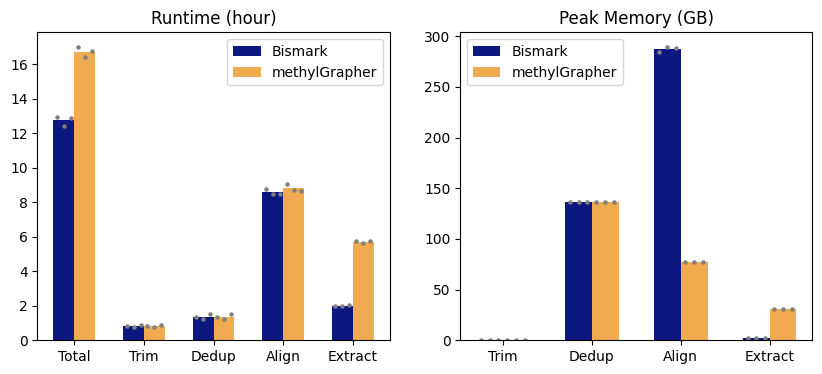

In [3]:
# Figure 2A and 2B





# OLD data tested on python 3.9
runtime_data_string = """1	0.8283333333333334	0.7780555555555555	0.8694444444444445
2	1.3736111111111111	1.2469444444444444	1.4966666666666666
3	1.1291666666666667	1.1547222222222222	1.2822222222222222
4	9.44	7.758611111111111	7.598055555555556
5	7.503333333333333	8.085277777777778	7.713333333333333
6	8.785555555555556	8.457222222222223	8.49
7	1.9727777777777777	1.9697222222222222	2.056388888888889""".strip().split("\n")

peak_mem_data_string = """1	0.193359375	0.1953125	0.1953125
2	136.2958984375	136.294921875	136.2958984375
3	0.0380859375	0.041015625	0.037109375
4	77.5537109375	77.6015625	77.5869140625
5	34.689453125	34.689453125	34.689453125
6	284.6513671875	289.4072265625	288.189453125
7	2.4248046875	2.736328125	2.580078125""".strip().split("\n")






# The result is updated based on more efficient version (python 3.12)
runtime_data_string = """1	0.8283333333333334	0.7780555555555555	0.8694444444444445
2	1.3736111111111111	1.2469444444444444	1.4966666666666666
3	1.1933333333333334	1.1294444444444445	1.16
4	7.871111111111111	7.5925	7.5
5	5.746944444444445	5.654444444444445	5.749444444444444
6	8.785555555555556	8.457222222222223	8.49
7	1.9727777777777777	1.9697222222222222	2.056388888888889""".strip().split("\n")

peak_mem_data_string = """1	0.193359375	0.1953125	0.1953125
2	136.2958984375	136.294921875	136.2958984375
3	0.01953125	0.025390625	0.025390625
4	77.5517578125	77.6123046875	77.57421875
5	31.1708984375	31.171875	31.1708984375
6	284.6513671875	289.4072265625	288.189453125
7	2.4248046875	2.736328125	2.580078125""".strip().split("\n")




runtime_data = {}
for l in runtime_data_string:
    l = l.strip().split("\t")
    runtime_data[int(l[0])] = list(map(float, l[1:]))


peak_mem_data = {}
for l in peak_mem_data_string:
    l = l.strip().split("\t")
    peak_mem_data[int(l[0])] = list(map(float, l[1:]))




fig2AB, axes2AB = plt.subplots(1, 2, figsize=(10, 4))
trim_time = runtime_data[1]
dedup_time = runtime_data[2]
mg_align_time = []
for i in range(3):
    mg_align_time.append(runtime_data[3][i] + runtime_data[4][i])
mg_extract_time = runtime_data[5]

bs_align_time = runtime_data[6]
bs_extract_time = runtime_data[7]

bs_total_time = []
mg_total_time = []
for i in range(3):
    bst0 = trim_time[i] + dedup_time[i] + bs_align_time[i] + bs_extract_time[i]
    mgt0 = trim_time[i] + dedup_time[i] + mg_align_time[i] + mg_extract_time[i]
    bs_total_time.append(bst0)
    mg_total_time.append(mgt0)

trim_time_average = sum(trim_time) / len(trim_time)
dedup_time_average = sum(dedup_time) / len(dedup_time)
mg_align_time_average = sum(mg_align_time) / len(mg_align_time)
mg_extract_time_average = sum(mg_extract_time) / len(mg_extract_time)
bs_align_time_average = sum(bs_align_time) / len(bs_align_time)
bs_extract_time_average = sum(bs_extract_time) / len(bs_extract_time)
bs_total_time_average = sum(bs_total_time) / len(bs_total_time)
mg_total_time_average = sum(mg_total_time) / len(mg_total_time)



x_mg = []
x_bs = []
for i in range(5):
    x_mg.append(i+0.15)
    x_bs.append(i-0.15)

y_mg = [mg_total_time_average, trim_time_average, dedup_time_average, mg_align_time_average, mg_extract_time_average]
y_bs = [bs_total_time_average, trim_time_average, dedup_time_average, bs_align_time_average, bs_extract_time_average]

axes2AB[0].bar(x_bs, y_bs, width=0.3, color=bs_color, label="Bismark")
axes2AB[0].bar(x_mg, y_mg, width=0.3, color=mg_color, label="methylGrapher")
axes2AB[0].set_xticks(range(5), ["Total", "Trim", "Dedup", "Align", "Extract"])
axes2AB[0].set_title("Runtime (hour)")
axes2AB[0].legend()

# Plot each dot

x_mg = []
x_bs = []
for i in range(5):
    for j in range(3):
        x_mg.append(i+0.15+(j-1)*0.1)
        x_bs.append(i-0.15+(j-1)*0.1)

y_mg = mg_total_time + trim_time + dedup_time + mg_align_time + mg_extract_time
y_bs = bs_total_time + trim_time + dedup_time + bs_align_time + bs_extract_time

axes2AB[0].scatter(x_mg, y_mg, color="gray", s=5)
axes2AB[0].scatter(x_bs, y_bs, color="gray", s=5)








# Memory
trim_mem = peak_mem_data[1]
dedup_mem = peak_mem_data[2]
mg_align_mem = peak_mem_data[4]
mg_extract_mem = peak_mem_data[5]

bs_align_mem = peak_mem_data[6]
bs_extract_mem = peak_mem_data[7]


trim_mem_average = sum(trim_mem) / len(trim_mem)
dedup_mem_average = sum(dedup_mem) / len(dedup_mem)
mg_align_mem_average = sum(mg_align_mem) / len(mg_align_mem)
mg_extract_mem_average = sum(mg_extract_mem) / len(mg_extract_mem)
bs_align_mem_average = sum(bs_align_mem) / len(bs_align_mem)
bs_extract_mem_average = sum(bs_extract_mem) / len(bs_extract_mem)


x_mg = []
x_bs = []
for i in range(4):
    x_mg.append(i+0.15)
    x_bs.append(i-0.15)

y_mg = [trim_mem_average, dedup_mem_average, mg_align_mem_average, mg_extract_mem_average]
y_bs = [trim_mem_average, dedup_mem_average, bs_align_mem_average, bs_extract_mem_average]

axes2AB[1].bar(x_bs, y_bs, width=0.3, color=bs_color, label="Bismark")
axes2AB[1].bar(x_mg, y_mg, width=0.3, color=mg_color, label="methylGrapher")
axes2AB[1].set_xticks(range(4), ["Trim", "Dedup", "Align", "Extract"])
axes2AB[1].set_title("Peak Memory (GB)")
axes2AB[1].legend()



# Plot each dot
x_mg = []
x_bs = []
for i in range(4):
    for j in range(3):
        x_mg.append(i+0.15+(j-1)*0.1)
        x_bs.append(i-0.15+(j-1)*0.1)

y_mg = trim_mem + dedup_mem + mg_align_mem + mg_extract_mem
y_bs = trim_mem + dedup_mem + bs_align_mem + bs_extract_mem

axes2AB[1].scatter(x_mg, y_mg, color="gray", s=5)
axes2AB[1].scatter(x_bs, y_bs, color="gray", s=5)







fig2AB.savefig(f"./figures/2AB.pdf", bbox_inches='tight')





HG00621 1
BS:  [100.0, 1.335, 4.8658, 31.1813, 4.2147, 0.0, 0.0001, 58.4033]
MG:  [100.0, 1.335, 4.8658, 9.5328, 7.6692, 0.3315, 0.0038, 76.262]

HG00621 2
BS:  [100.0, 0.204, 5.5643, 26.2873, 4.23, 0.0, 0.0001, 63.7144]
MG:  [100.0, 0.204, 5.5643, 8.4585, 7.2993, 0.315, 0.0037, 78.1551]

HG00741 1
BS:  [100.0, 0.3577, 4.8993, 23.516, 4.0195, 0.0, 0.0, 67.2075]
MG:  [100.0, 0.3577, 4.8993, 7.6101, 6.9319, 0.1875, 0.0026, 80.0109]

HG00741 2
BS:  [100.0, 0.3957, 4.2471, 22.168, 4.1108, 0.0, 0.0, 69.0784]
MG:  [100.0, 0.3957, 4.2471, 7.6532, 6.9423, 0.1783, 0.0027, 80.5808]

HG01952 1
BS:  [100.0, 0.3539, 2.4887, 38.5542, 3.2785, 0.0, 0.0001, 55.3246]
MG:  [100.0, 0.3539, 2.4887, 8.094, 7.4435, 0.5425, 0.0055, 81.0718]

HG01952 2
BS:  [100.0, 2.0224, 4.9192, 27.9244, 3.7548, 0.0, 0.0001, 61.3792]
MG:  [100.0, 2.0224, 4.9192, 7.9508, 7.0981, 0.2426, 0.0043, 77.7627]

HG01978 1
BS:  [100.0, 0.9402, 2.6441, 40.6752, 3.3775, 0.0, 0.0001, 52.363]
MG:  [100.0, 0.9402, 2.6441, 9.0641, 7.9727, 0

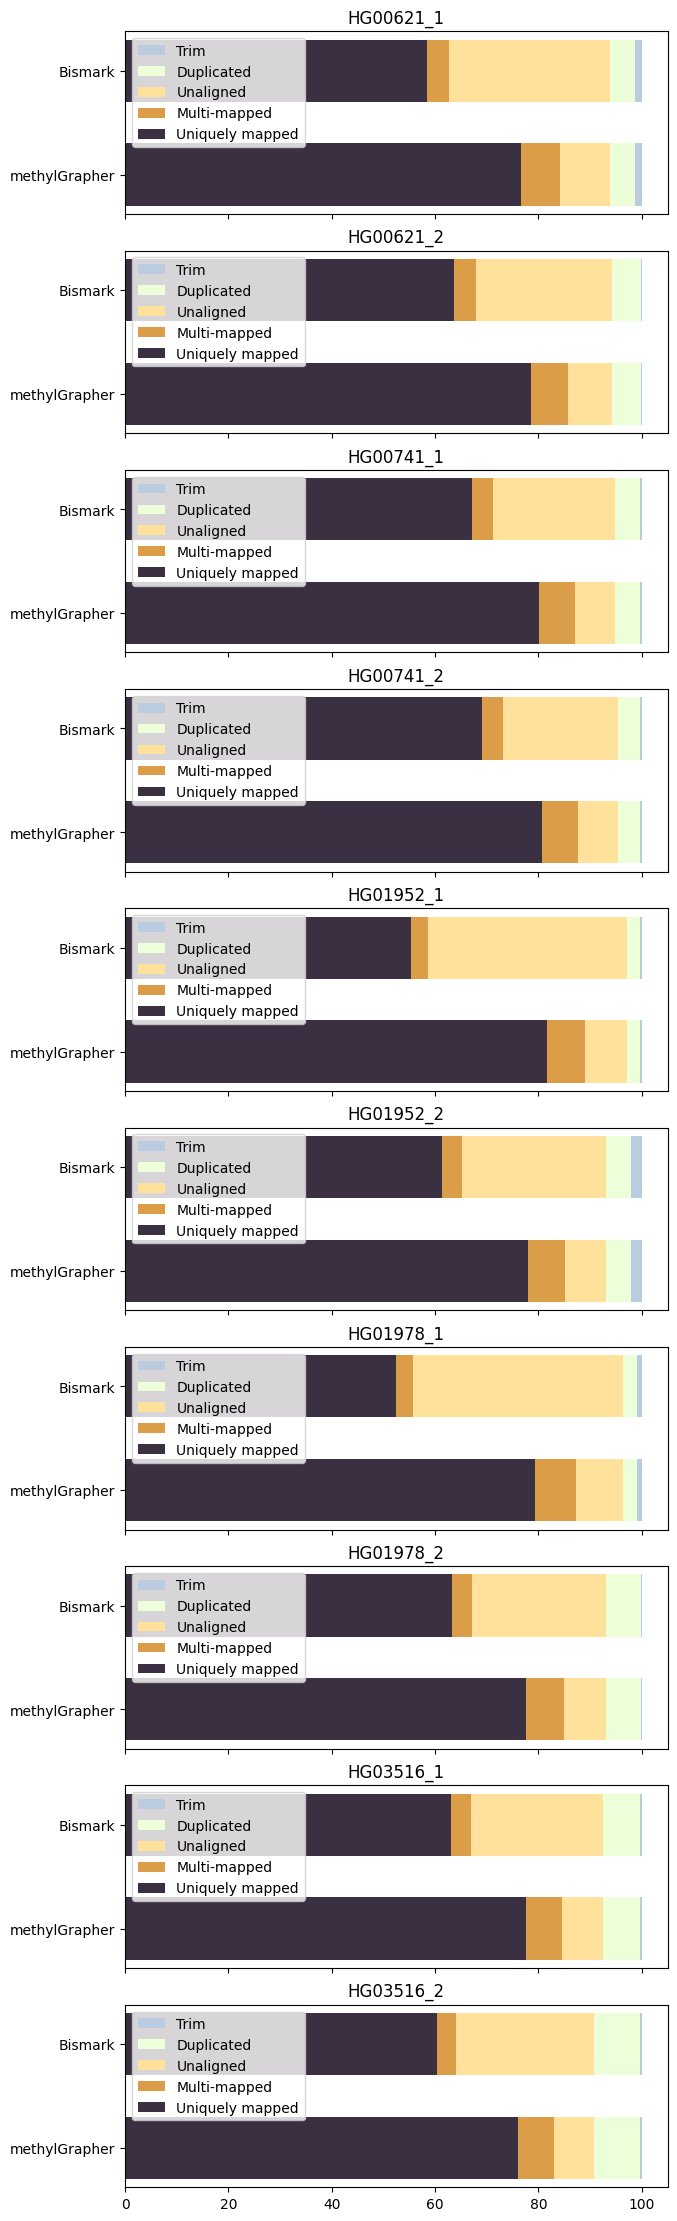

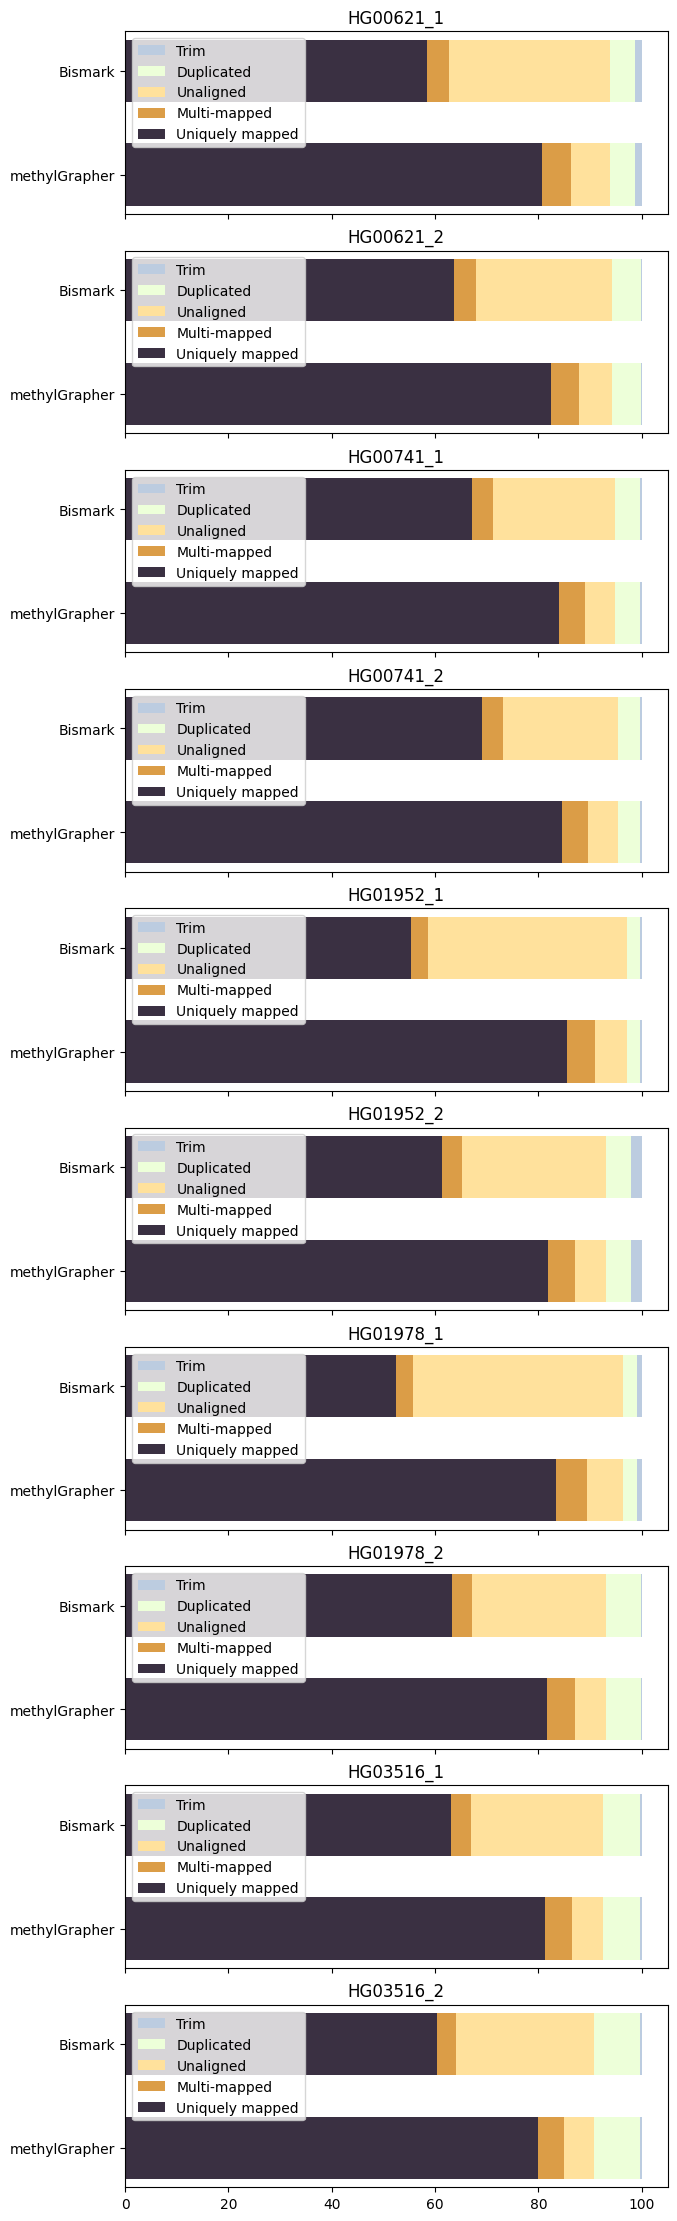

In [41]:
# Figure 2C

read_fate_bs = {}
read_fate_mg = {}



read_fate_methylgrapher_string_pan = """HG00621 1       632425760       623983088       593210520       266461428       24250864        1048153 12168
HG00621 2       693368864       691954268       653372836       297361986       25305574        1092111 12759
HG00741 1       828587944       825623948       785028916       360986439       28718507        776981  10753
HG00741 2       669297276       666649168       638223296       293500423       23232185        596797  8934
HG01952 1       761988944       759292520       740328588       339326456       28359494        2066937 20874
HG01952 2       842572440       825532616       784084512       358546543       29903159        1022015 17924
HG01978 1       762254308       755087848       734933272       332920867       30386006        2110009 20226
HG01978 2       1022644704      1020912880      950967944       434638616       37702042        1109169 20102
HG03516 1       1077846324      1074625584      996966416       456196447       38180494        1072088 16357
HG03516 2       1131705808      1128505180      1027927044      470228302       39453210        1742697 21457"""


read_fate_methylgrapher_string_bspg = """HG00621 1       632425760       623983088       593210520       272846163       17900783        1048551 5428
HG00621 2       693368864       691954268       653372836       304393847       18303408        1095824 5874
HG00741 1       828587944       825623948       785028916       368891946       20834772        787386  5001
HG00741 2       669297276       666649168       638223296       299933198       16824151        604805  4234
HG01952 1       761988944       759292520       740328588       346817775       20868941        2074262 8971
HG01952 2       842572440       825532616       784084512       366538786       21956053        1021801 7962
HG01978 1       762254308       755087848       734933272       340735845       22540452        2126319 9374
HG01978 2       1022644704      1020912880      950967944       445193280       27155523        1121168 9766
HG03516 1       1077846324      1074625584      996966416       466400677       27983441        1086386 7571
HG03516 2       1131705808      1128505180      1027927044      480702777       28975967        1763044 10140"""




read_fate_bs_tmp = {}
for s in samples:
    read_fate_bs_tmp[s] = {}
    for r in replicates:

        # bismark_hg38_default
        # bismark_hg38_fu
        bs_report_fp = f"/scratch/wzhang/projects/ggWGBS/bismark_hg38_default/{s}/{r}/R1_bismark_bt2_PE_report.txt"
        
        for l in open(bs_report_fp):
            if "Sequence pairs analysed in tota" in l:
                sequence_pairs = int(l.strip().split()[-1])
            if "Sequence pairs with no alignments under any condition" in l:
                unaligned = int(l.strip().split()[-1])
            if "Sequence pairs did not map uniquely" in l:
                multimapped = int(l.strip().split()[-1])
            if "Sequence pairs which were discarded because genomic sequence could not be extracted" in l:
                issue = int(l.strip().split()[-1])
            if "Number of paired-end alignments with a unique best hit" in l:
                informative = int(l.strip().split()[-1])
        
        # print(s, r)
        read_fate_bs_tmp[s][r] = [unaligned*2, multimapped*2, 0, issue*2, informative*2]
        # print(s, r)
        # print(s, r, read_fate_bs_tmp[s][r])
        # print()




mg_result = "pan" # bspg or pan

for mg_result in ["pan", "bspg"]:


    read_fate_methylgrapher_string = read_fate_methylgrapher_string_bspg if mg_result == "bspg" else read_fate_methylgrapher_string_pan


    fig2C, axes2C = plt.subplots(10, 1, sharex=True, sharey=True, figsize=(7, 28))

    axes_i = 0
    for l in read_fate_methylgrapher_string.split("\n"):
        l = l.strip().split()
        for i in range(2, 9):
            l[i] = int(l[i])

        sample, replicate, raw_reads, after_trim, after_dedup, aligned, multimapped, low_confidence, issue = l

        replicate = int(replicate)

        # Those I counted the lines in fastq files, read-pairs count should be divided by 4, read count should be divided by 2
        raw_reads = int(raw_reads / 2)
        after_trim = int(after_trim / 2)
        after_dedup = int(after_dedup / 2)

        # print(sample, replicate, raw_reads, after_trim, after_dedup, aligned, multimapped, low_confidence, issue)

        total = raw_reads
        trim = raw_reads - after_trim
        dedup = after_trim - after_dedup
        unaligned = after_dedup - aligned
        informative = aligned - multimapped - low_confidence - issue


        read_fate_mg[sample] = {
            replicate: [total, trim, dedup, unaligned, multimapped, low_confidence, issue, informative]
        }

        read_fate_bs[sample] = {
            replicate: [total, trim, dedup] + read_fate_bs_tmp[sample][replicate]
        }

        if True:
            read_fate_bs[sample][replicate] = list(map(lambda x: round(x/total*100, 4), read_fate_bs[sample][replicate]))
            read_fate_mg[sample][replicate] = list(map(lambda x: round(x/total*100, 4), read_fate_mg[sample][replicate]))

        print(sample, replicate)
        print("BS: ", list(map(lambda x: x, read_fate_bs[sample][replicate])))
        print("MG: ", list(map(lambda x: x, read_fate_mg[sample][replicate])))

        #print("BS: ", list(map(lambda x: round(x/total*100, 2), read_fate_bs[sample][replicate])))
        #print("MG: ", list(map(lambda x: round(x/total*100, 2), read_fate_mg[sample][replicate])))
        print()

        bar_x = ["Bismark", "methylGrapher"][::-1]

        bar_informative = np.array([read_fate_bs[sample][replicate][7], read_fate_mg[sample][replicate][7]][::-1])
        bar_low_conf =    np.array([read_fate_bs[sample][replicate][5], read_fate_mg[sample][replicate][5]][::-1])
        bar_multimapped = np.array([read_fate_bs[sample][replicate][4], read_fate_mg[sample][replicate][4]][::-1])
        bar_unaligned =   np.array([read_fate_bs[sample][replicate][3], read_fate_mg[sample][replicate][3]][::-1])
        bar_dedup =       np.array([read_fate_bs[sample][replicate][2], read_fate_mg[sample][replicate][2]][::-1])
        bar_trim =        np.array([read_fate_bs[sample][replicate][1], read_fate_mg[sample][replicate][1]][::-1])


        colors_stacked = ["#51a586", "#43828c", "#3f5f89", "#44357c", "#3e1050"]

        # I like this in reversed
        colors_stacked = ["#967D69", "#92B9BD", "#A8D4AD", "#F2F79E", "#E8EC67"]
        colors_stacked = ["#312F2F", "#84DCCF", "#A6D9F7", "#BCCCE0", "#BF98A0"]

        colors_stacked = ["#3A3042", "#DB9D47", "#FFE19C", "#EDFFD9", "#BCCCE0"]
        
        colors_stacked = list(reversed(colors_stacked))
        
        axes2C[axes_i].barh(bar_x, bar_trim,        left=bar_informative+bar_low_conf+bar_multimapped+bar_unaligned+bar_dedup, label="Trim", color=colors_stacked[0], height=0.6)
        axes2C[axes_i].barh(bar_x, bar_dedup,       left=bar_informative+bar_low_conf+bar_multimapped+bar_unaligned, label="Duplicated", color=colors_stacked[1], height=0.6)
        axes2C[axes_i].barh(bar_x, bar_unaligned,   left=bar_informative+bar_low_conf+bar_multimapped, label="Unaligned", color=colors_stacked[2], height=0.6)
        axes2C[axes_i].barh(bar_x, bar_multimapped, left=bar_informative+bar_low_conf, label="Multi-mapped", color=colors_stacked[3], height=0.6)
        # axes2C[axes_i].barh(bar_x, bar_low_conf,    left=bar_informative, label="Low-confidence")
        axes2C[axes_i].barh(bar_x, bar_informative+bar_low_conf, label="Uniquely mapped", color=colors_stacked[4], height=0.6)

        axes2C[axes_i].set_title(f"{sample}_{replicate}")
        axes2C[axes_i].legend()
        # axes2C[axes_i].set_xticks()

        axes_i += 1

    fig2C.savefig(f"./figures/2C.{mg_result}.pdf", bbox_inches='tight')



In [ ]:
# Figure 3


# 3A 1D-density for methylation (merge replicates)
# 3C Coverage distribution




fig3A, axes3A = plt.subplots(2, 5, sharex=True, figsize=(30, 9))
fig3C, axes3C = plt.subplots(2, 5, sharex=True, figsize=(30, 9))

# seaborn.barplot(ax=axes[0], x=bulbasaur.index, y=bulbasaur.values)


cpg_counts = {}
for s in samples:

    cpg_counts[s] = {}

    for r in replicates:
        print(s, r)

        axes_xi = samples.index(s)
        axes_yi = replicates.index(r)

        # ML Density plot
        mg_ml = []
        bs_ml = []

        # CpG counts
        mg_cpg_count = 0
        bs_cpg_count = 0

        mg_cpg_count_hc = 0
        bs_cpg_count_hc = 0


        # Coverage distribution
        mg_cov = []
        bs_cov = []


        for chrom in bismark_cpg_data[s][r]:
            xxx = bismark_cpg_data[s][r][chrom]
            for start, (met, cov) in xxx.items():
                bs_cpg_count += 1

                covx = cov
                if covx > 30:
                    covx = 30
                # bs_cov[covx] += 1
                bs_cov.append(covx)

                if cov <= min_cov:
                    continue

                bs_cpg_count_hc += 1
                bs_ml.append(met/cov)

        for cpg_id, (met, cov) in methylgrapher_cpg_data[s][r].items():
            mg_cpg_count += 1

            covx = cov
            if covx > 30:
                covx = 30
            # mg_cov[covx] += 1
            mg_cov.append(covx)

            if cov <= min_cov:
                continue


            mg_cpg_count_hc += 1
            mg_ml.append(met/cov)


        print("\t", bs_cpg_count, mg_cpg_count, bs_cpg_count_hc, mg_cpg_count_hc)

        cpg_counts[s][r] = [bs_cpg_count, mg_cpg_count, bs_cpg_count_hc, mg_cpg_count_hc]


        seaborn.kdeplot(np.array(bs_ml), bw_method=0.08, ax=axes3A[axes_yi, axes_xi], color=bs_color, label="Bismark")
        seaborn.kdeplot(np.array(mg_ml), bw_method=0.08, ax=axes3A[axes_yi, axes_xi], color=mg_color, label="methylGrapher", linestyle="dashed")
        axes3A[axes_yi, axes_xi].set_title(f"{s}_{r}")
        axes3A[axes_yi, axes_xi].legend()


        for method in ["Bismark", "methylGrapher"]:
            cov = bs_cov if method == "Bismark" else mg_cov
            color = bs_color if method == "Bismark" else mg_color

            ave_cov = sum(cov) / len(cov)
            x = []
            y = []

            for i in range(1, 31):
                x.append(i)
                y.append(cov.count(i)/len(cov))
            axes3C[axes_yi, axes_xi].plot(x, y, label=f"{method}", color=color)
            axes3C[axes_yi, axes_xi].set_title(f"{s}_{r}")
            axes3C[axes_yi, axes_xi].plot([ave_cov, ave_cov], [0, max(y)], color=color, linestyle="--")
            axes3C[axes_yi, axes_xi].set_xticks(range(0, 31, 5))
        axes3C[axes_yi, axes_xi].legend()


        #seaborn.kdeplot(np.array(bs_cov), bw_method=0.03, ax=axes3C[axes_yi, axes_xi], color=bs_color)
        #seaborn.kdeplot(np.array(mg_cov), bw_method=0.03, ax=axes3C[axes_yi, axes_xi], color=mg_color)


        # TODO not necessary, just for debugging
        fig3A.savefig("./figures/3A.pdf", bbox_inches='tight')
        fig3C.savefig("./figures/3C.pdf", bbox_inches='tight')


        # break
    # break



fig3A.savefig("./figures/3A.pdf", bbox_inches='tight')
fig3C.savefig("./figures/3C.pdf", bbox_inches='tight')



fig3B, axes3B = plt.subplots(1, 1, figsize=(10, 5))


x1 = []
x2 = []
for i in range(10):
    x1.append(i-0.2)
    x2.append(i+0.2)

y1, y2, y3, y4 = [], [], [], []
for s in samples:
    for r in replicates:
        y1b = cpg_counts[s][r][0]
        y2b = cpg_counts[s][r][1]

        y3b = cpg_counts[s][r][2]
        y4b = cpg_counts[s][r][3]

        y1.append(y1b)
        y2.append(y2b)
        y3.append(y3b)
        y4.append(y4b)

axes3B.bar(x1, y1, width=0.4, color=bs_color, label="Bismark", alpha=0.5)
axes3B.bar(x2, y2, width=0.4, color=mg_color, label="methylGrapher", alpha=0.5)

axes3B.bar(x1, y3, width=0.4, color=bs_color, label="Bismark")
axes3B.bar(x2, y4, width=0.4, color=mg_color, label="methylGrapher")


axes3B.set_title("CpG count")

axes3B.set_xticks(range(10))
axes3B.set_xticklabels([f"{s}_{r}" for s in samples for r in replicates], rotation=45)


axes3B.set_yticks(range(0, int(3e7)+1, int(5e6)))
axes3B.set_yticklabels([f"{int(i//1e6)}M" for i in range(0, int(3e7)+1, int(5e6))])



# axes3B.legend()




fig3B.savefig("./figures/3B.pdf", bbox_inches='tight')




In [29]:
# Figure 4 Helper Functions




def linear_regression(x, y):
    x = np.array(x).reshape((-1, 1))
    y = np.array(y)

    model = LinearRegression()
    model.fit(x, y)

    k = model.coef_[0]
    b = model.intercept_

    r_sq = model.score(x, y)

    return k, b, r_sq

def pearson(x, y):
    x = np.array(x)
    y = np.array(y)
    r = scipy.stats.pearsonr(x, y)[0]
    return r


def density2d(x, y, bin=40, log=None):
    assert len(x) == len(y)

    shape = (bin+1, bin+1)
    step = 1 / bin
    res = numpy.ones(shape)

    total = 0
    for i in range(len(x)):
        x0 = x[i]
        y0 = y[i]

        # yi = bin - int(x0 / step)
        # xi = int(y0 / step)
        xi = int(x0 / step)
        yi = int(y0 / step)

        # print(x0, xi, y0, yi, step)

        res[xi, yi] += 1

    mm = numpy.max(res)
    total = numpy.sum(res)

    for a in range(bin+1):
        for b in range(bin+1):
            pass
            # print(res[a, b])
            # res[a, b] = math.log2(res[a, b]/total)
            res[a, b] = res[a, b] / mm
            if log != None:
                res[a, b] = math.log2(res[a, b])
            # print(res[a, b])


    return res



def density2dInt(x, y, log=None):
    assert len(x) == len(y)

    lowest = 0
    highest = max(x+y)

    shape = (highest+1, highest+1)
    step = 1
    res = numpy.ones(shape)

    total = 0
    for i in range(len(x)):
        x0 = x[i]
        y0 = y[i]

        # yi = bin - int(x0 / step)
        # xi = int(y0 / step)
        xi = int(x0 / step)
        yi = int(y0 / step)

        # print(x0, xi, y0, yi, step)

        res[xi, yi] += 1

    mm = numpy.max(res)
    total = numpy.sum(res)

    for a in range(highest+1):
        for b in range(highest+1):
            pass
            # print(res[a, b])
            # res[a, b] = math.log2(res[a, b]/total)
            res[a, b] = res[a, b] / mm
            if log != None:
                res[a, b] = math.log2(res[a, b])
            # print(res[a, b])


    return res


def diff_bar_graph_data(delta):

    delta_x = []
    delta_y = []


    diff = [0.1, 0.2, 0.3, 0.4, 0.5]
    for i in range(1, 10):
        diff_range_center = i / 10 - 0.5
        delta_x.append(diff_range_center)
        delta_y.append(0)



    for d in delta:
        if d < -0.45:
            d = -0.45
        if d > 0.44:
            d = 0.44

        for idx, dc in enumerate(delta_x):
            if abs(dc - d) < 0.05:
                delta_y[idx] += 1

    return delta_x, delta_y





HG00621
	Y= 0.8769X + 72.1673, R^2 = 0.7724 Pearson = 0.8788 N=8.5M
HG00741
	Y= 0.8889X + 68.4684, R^2 = 0.7742 Pearson = 0.8799 N=16.1M
HG01952
	Y= 0.8577X + 66.4786, R^2 = 0.7520 Pearson = 0.8672 N=12.1M
HG01978
	Y= 0.8629X + 67.4624, R^2 = 0.7707 Pearson = 0.8779 N=11.7M
HG03516
	Y= 0.8963X + 71.0695, R^2 = 0.7989 Pearson = 0.8938 N=20.6M


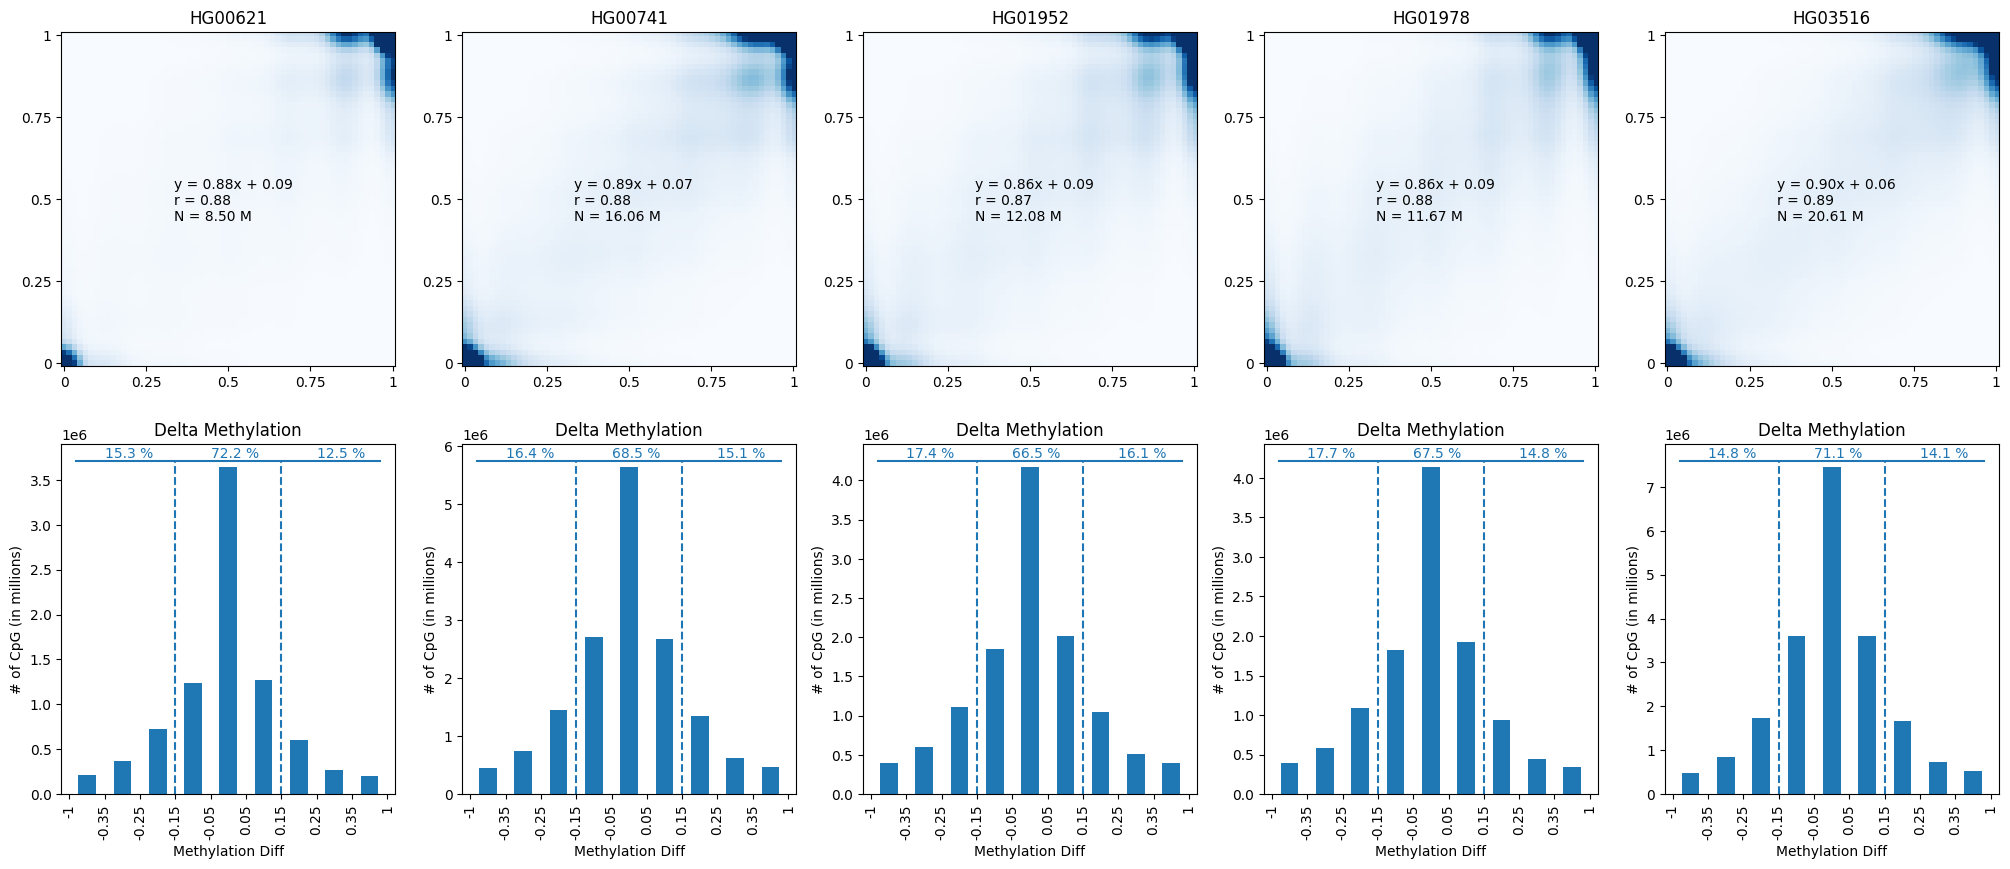

In [32]:
# Figure 4A


fig4A, axes4A = plt.subplots(2, 5, figsize=(25, 10))
for s in samples:
    print(s)

    ml_delta = []
    bs_cpg_ml_r1 = []
    bs_cpg_ml_r2 = []


    bsd_r1 = bismark_cpg_data[s][replicates[0]]
    bsd_r2 = bismark_cpg_data[s][replicates[1]]


    for chrom in bsd_r1:
        if chrom not in bsd_r2:
            continue

        for pos in bsd_r1[chrom]:
            pos = int(pos)

            bsd01 = bsd_r1[chrom][pos]
            if pos not in bsd_r2[chrom]:
                continue
            bsd02 = bsd_r2[chrom][pos]

            if bsd01[1] <= min_cov or bsd02[1] <= min_cov:
                continue

            ml1 = bsd01[0] / bsd01[1]
            ml2 = bsd02[0] / bsd02[1]

            diff = ml1 - ml2
            ml_delta.append(diff)

            bs_cpg_ml_r1.append(ml1)
            bs_cpg_ml_r2.append(ml2)

    k, b, r2 = linear_regression(bs_cpg_ml_r1, bs_cpg_ml_r2)
    r_pearson = pearson(bs_cpg_ml_r1, bs_cpg_ml_r2)






    hmd20 = density2d(bs_cpg_ml_r1, bs_cpg_ml_r2, bin=20)
    hmd30 = density2d(bs_cpg_ml_r1, bs_cpg_ml_r2, bin=30)
    hmd40 = density2d(bs_cpg_ml_r1, bs_cpg_ml_r2, bin=40)
    hmd50 = density2d(bs_cpg_ml_r1, bs_cpg_ml_r2, bin=50)
    hmd60 = density2d(bs_cpg_ml_r1, bs_cpg_ml_r2, bin=60)
    hmd70 = density2d(bs_cpg_ml_r1, bs_cpg_ml_r2, bin=70)
    hmd80 = density2d(bs_cpg_ml_r1, bs_cpg_ml_r2, bin=80)
    hmd90 = density2d(bs_cpg_ml_r1, bs_cpg_ml_r2, bin=90)
    hmd100 = density2d(bs_cpg_ml_r1, bs_cpg_ml_r2, bin=100)


    hmd = copy.deepcopy(hmd60)

    dim0 = hmd.shape[0]
    bcount = dim0-1
    bcount_half = int(bcount/2)

    newhmd = np.zeros(hmd.shape)
    for xo in range(dim0):
        for yo in range(dim0):
            xn = dim0-1 - yo
            yn = xo
            newhmd[xn, yn] = hmd[xo, yo]
    hmd = newhmd


    axes_xi = samples.index(s)


    ax1 = axes4A[0, axes_xi]
    ax2 = axes4A[1, axes_xi]

    ax1.set_xticks([0, 0.25*bcount, 0.5*bcount, 0.75*bcount, bcount], [0, 0.25, 0.5, 0.75, 1])
    ax1.set_yticks([bcount, 0.75*bcount, 0.5*bcount, 0.25*bcount, 0], [0, 0.25, 0.5, 0.75, 1])


    hmd_gb = gaussian_filter(hmd, sigma=2)
    im = ax1.imshow(hmd_gb, cmap="Blues", vmin=0, vmax=0.02) # , vmin=0, vmax=0.02


    ax1.text(20, 34, f"y = {k:0.2f}x + {b:0.2f}\nr = {r_pearson:0.2f}\nN = {len(bs_cpg_ml_r1)/1e6:0.2f} M", fontsize=10, color="black")
    ax1.set_title(f"{s}")

    # ax1.colorbar(im, fraction=0.02)




    # seaborn.kdeplot(np.array(ml_delta), bw_method=0.1, ax=ax2)
    delta_x, delta_y = diff_bar_graph_data(ml_delta)
    ax2.bar(delta_x, delta_y, width=0.05)

    # Updates
    ax2.set_title(f"Delta Methylation")
    ax2.set_xlabel("Methylation Diff")
    ax2.set_ylabel("# of CpG (in millions)")
    
    y0 = max(delta_y) * 1.02
    ax2.plot([-0.43, 0.43], [y0, y0], color='#1f76b4',)
    ax2.plot([0.15, 0.15], [0, y0], linestyle='dashed', color='#1f76b4',)
    ax2.plot([-0.15, -0.15], [0, y0], linestyle='dashed', color='#1f76b4',)

    t = [-0.45, -0.35, -0.25, -0.15, -0.05, 0.05, 0.15, 0.25, 0.35, 0.45]
    tl = [-1, -0.35, -0.25, -0.15, -0.05, 0.05, 0.15, 0.25, 0.35, 1]
    ax2.set_xticks(t, tl, rotation='vertical')

    a = sum(delta_y[:3]) / sum(delta_y) * 100
    b = sum(delta_y[3:6]) / sum(delta_y) * 100
    c = sum(delta_y[6:]) / sum(delta_y) * 100

    ax2.text(-0.35, y0*1.01, f"{a:0.1f} %", fontsize=10, color="#1f76b4")
    ax2.text(-0.05, y0*1.01, f"{b:0.1f} %", fontsize=10, color="#1f76b4")
    ax2.text( 0.25, y0*1.01, f"{c:0.1f} %", fontsize=10, color="#1f76b4")
    



    fig4A.savefig(f"./figures/4A.pdf", bbox_inches="tight")

    assert len(bs_cpg_ml_r1) == len(bs_cpg_ml_r2)
    print(f"\tY= {k:0.4f}X + {b:0.4f}, R^2 = {r2:0.4f} Pearson = {r_pearson:0.4f} N={len(bs_cpg_ml_r1)/1e6:0.1f}M")





HG00621
	Y= 0.8816X + 73.1180, R^2 = 0.7779 Pearson = 0.8820 N=15.8M
HG00741
	Y= 0.8979X + 69.9302, R^2 = 0.7877 Pearson = 0.8875 N=21.0M
HG01952
	Y= 0.8772X + 68.9080, R^2 = 0.7737 Pearson = 0.8796 N=21.4M
HG01978
	Y= 0.8811X + 69.6461, R^2 = 0.7869 Pearson = 0.8871 N=21.9M
HG03516
	Y= 0.9077X + 73.6129, R^2 = 0.8234 Pearson = 0.9074 N=25.4M


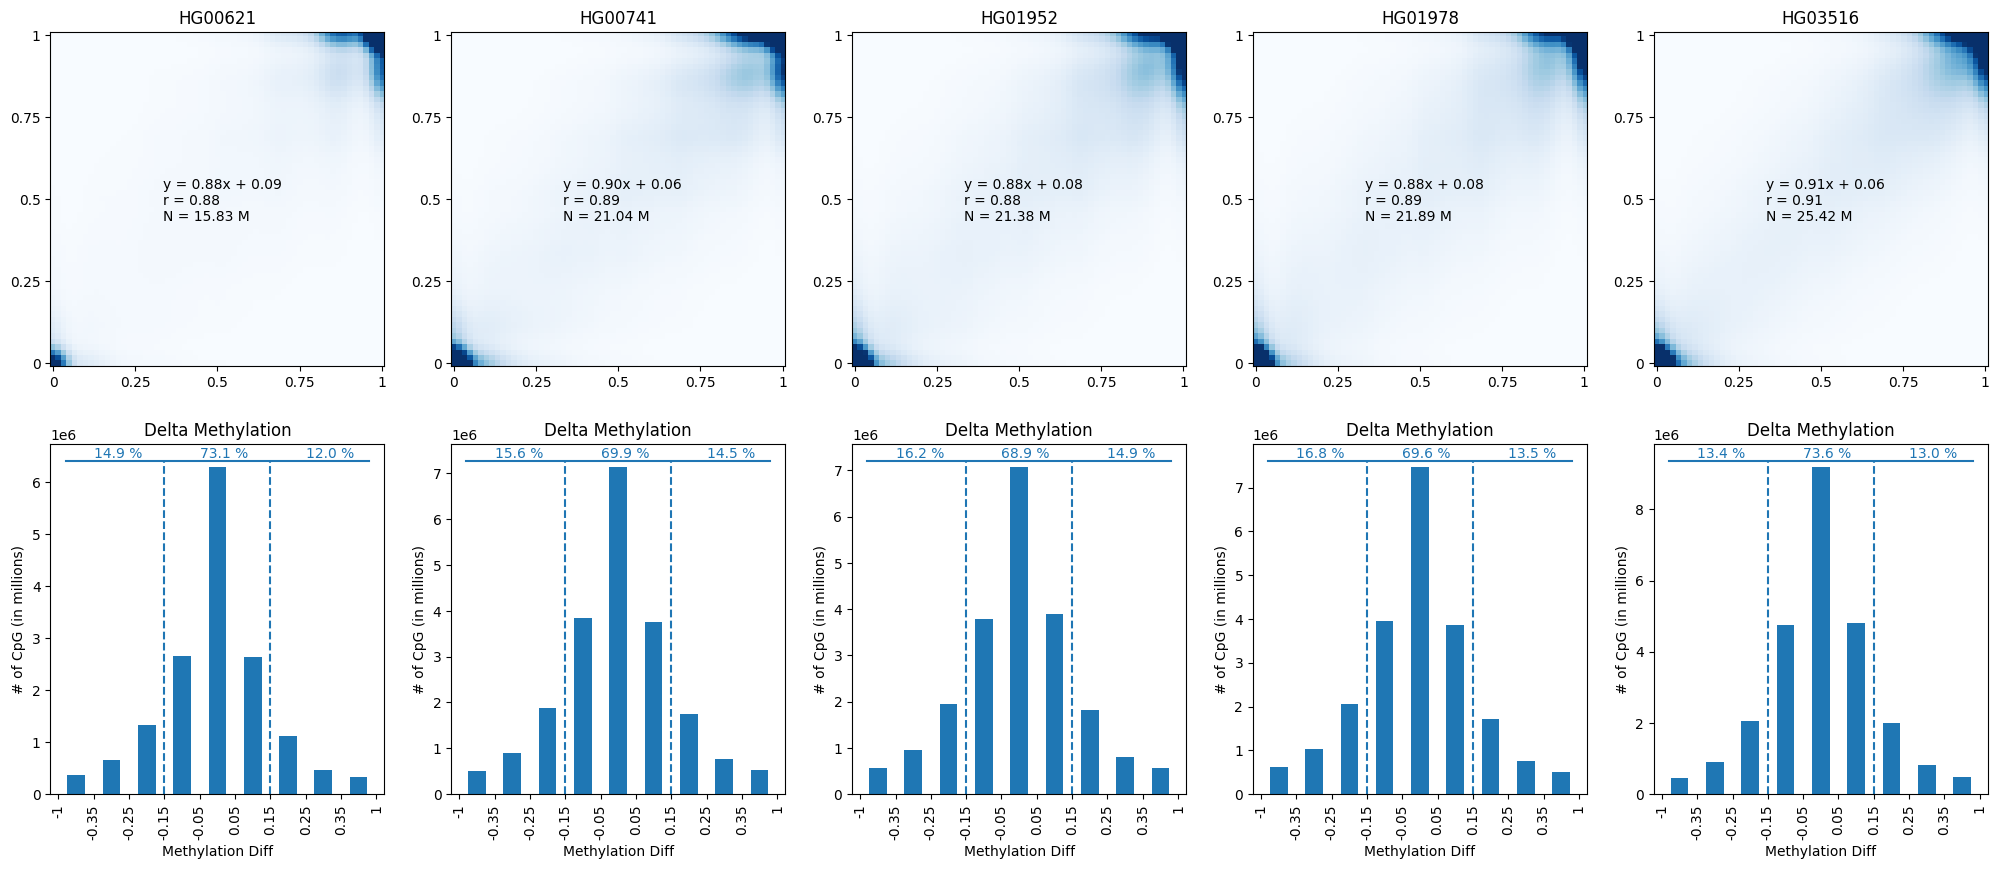

In [31]:
# Figure 4B


fig4B, axes4B = plt.subplots(2, 5, figsize=(25, 10))
for s in samples:
    print(s)

    ml_delta = []
    mg_cpg_ml_r1 = []
    mg_cpg_ml_r2 = []


    mgd_r1 = methylgrapher_cpg_data[s][replicates[0]]
    mgd_r2 = methylgrapher_cpg_data[s][replicates[1]]


    for cpg_id in mgd_r1:
        if cpg_id not in mgd_r2:
            continue


        mgd01 = mgd_r1[cpg_id]
        mgd02 = mgd_r2[cpg_id]

        if mgd01[1] <= min_cov or mgd02[1] <= min_cov:
            continue

        ml1 = mgd01[0] / mgd01[1]
        ml2 = mgd02[0] / mgd02[1]

        diff = ml1 - ml2
        ml_delta.append(diff)

        mg_cpg_ml_r1.append(ml1)
        mg_cpg_ml_r2.append(ml2)

    k, b, r2 = linear_regression(mg_cpg_ml_r1, mg_cpg_ml_r2)
    r_pearson = pearson(mg_cpg_ml_r1, mg_cpg_ml_r2)



    hmd20 = density2d(mg_cpg_ml_r1, mg_cpg_ml_r2, bin=20)
    hmd30 = density2d(mg_cpg_ml_r1, mg_cpg_ml_r2, bin=30)
    hmd40 = density2d(mg_cpg_ml_r1, mg_cpg_ml_r2, bin=40)
    hmd50 = density2d(mg_cpg_ml_r1, mg_cpg_ml_r2, bin=50)
    hmd60 = density2d(mg_cpg_ml_r1, mg_cpg_ml_r2, bin=60)
    hmd70 = density2d(mg_cpg_ml_r1, mg_cpg_ml_r2, bin=70)
    hmd80 = density2d(mg_cpg_ml_r1, mg_cpg_ml_r2, bin=80)
    hmd90 = density2d(mg_cpg_ml_r1, mg_cpg_ml_r2, bin=90)
    hmd100 = density2d(mg_cpg_ml_r1, mg_cpg_ml_r2, bin=100)


    hmd = copy.deepcopy(hmd60)

    dim0 = hmd.shape[0]
    bcount = dim0-1
    bcount_half = int(bcount/2)

    newhmd = np.zeros(hmd.shape)
    for xo in range(dim0):
        for yo in range(dim0):
            xn = dim0-1 - yo
            yn = xo
            newhmd[xn, yn] = hmd[xo, yo]
    hmd = newhmd


    axes_xi = samples.index(s)


    ax1 = axes4B[0, axes_xi]
    ax2 = axes4B[1, axes_xi]

    ax1.set_xticks([0, 0.25*bcount, 0.5*bcount, 0.75*bcount, bcount], [0, 0.25, 0.5, 0.75, 1])
    ax1.set_yticks([bcount, 0.75*bcount, 0.5*bcount, 0.25*bcount, 0], [0, 0.25, 0.5, 0.75, 1])


    hmd_gb = gaussian_filter(hmd, sigma=2)
    im = ax1.imshow(hmd_gb, cmap="Blues", vmin=0, vmax=0.03) # , vmin=0, vmax=0.02


    ax1.text(20, 34, f"y = {k:0.2f}x + {b:0.2f}\nr = {r_pearson:0.2f}\nN = {len(mg_cpg_ml_r1)/1e6:0.2f} M", fontsize=10, color="black")
    ax1.set_title(f"{s}")

    # ax1.colorbar(im, fraction=0.02)


    # seaborn.kdeplot(np.array(ml_delta), bw_method=0.1, ax=ax2)
    delta_x, delta_y = diff_bar_graph_data(ml_delta)
    ax2.bar(delta_x, delta_y, width=0.05)
    
    ax2.set_title(f"Delta Methylation")
    ax2.set_xlabel("Methylation Diff")
    ax2.set_ylabel("# of CpG (in millions)")
    
    y0 = max(delta_y) * 1.02
    ax2.plot([-0.43, 0.43], [y0, y0], color='#1f76b4',)
    ax2.plot([0.15, 0.15], [0, y0], linestyle='dashed', color='#1f76b4',)
    ax2.plot([-0.15, -0.15], [0, y0], linestyle='dashed', color='#1f76b4',)

    t = [-0.45, -0.35, -0.25, -0.15, -0.05, 0.05, 0.15, 0.25, 0.35, 0.45]
    tl = [-1, -0.35, -0.25, -0.15, -0.05, 0.05, 0.15, 0.25, 0.35, 1]
    ax2.set_xticks(t, tl, rotation='vertical')

    a = sum(delta_y[:3]) / sum(delta_y) * 100
    b = sum(delta_y[3:6]) / sum(delta_y) * 100
    c = sum(delta_y[6:]) / sum(delta_y) * 100

    ax2.text(-0.35, y0*1.01, f"{a:0.1f} %", fontsize=10, color="#1f76b4")
    ax2.text(-0.05, y0*1.01, f"{b:0.1f} %", fontsize=10, color="#1f76b4")
    ax2.text( 0.25, y0*1.01, f"{c:0.1f} %", fontsize=10, color="#1f76b4")


    fig4B.savefig(f"./figures/4B.pdf", bbox_inches="tight")

    assert len(mg_cpg_ml_r1) == len(mg_cpg_ml_r2)
    print(f"\tY= {k:0.4f}X + {b:0.4f}, R^2 = {r2:0.4f} Pearson = {r_pearson:0.4f} N={len(mg_cpg_ml_r2)/1e6:0.1f}M")




HG00621 1
	Y= 0.9644X + 96.1652, R^2 = 0.9641 Pearson = 0.9819 N=11.2M
HG00621 2
	Y= 0.9668X + 96.7908, R^2 = 0.9663 Pearson = 0.9830 N=15.2M
HG00741 1
	Y= 0.9699X + 96.6811, R^2 = 0.9696 Pearson = 0.9847 N=20.8M
HG00741 2
	Y= 0.9732X + 97.0736, R^2 = 0.9731 Pearson = 0.9865 N=17.8M
HG01952 1
	Y= 0.9465X + 93.0127, R^2 = 0.9499 Pearson = 0.9746 N=13.7M
HG01952 2
	Y= 0.9599X + 95.2688, R^2 = 0.9617 Pearson = 0.9807 N=18.7M
HG01978 1
	Y= 0.9469X + 92.4392, R^2 = 0.9506 Pearson = 0.9750 N=12.1M
HG01978 2
	Y= 0.9616X + 95.4349, R^2 = 0.9634 Pearson = 0.9815 N=21.5M
HG03516 1
	Y= 0.9651X + 95.8915, R^2 = 0.9656 Pearson = 0.9826 N=22.4M
HG03516 2
	Y= 0.9613X + 95.2593, R^2 = 0.9622 Pearson = 0.9809 N=22.0M


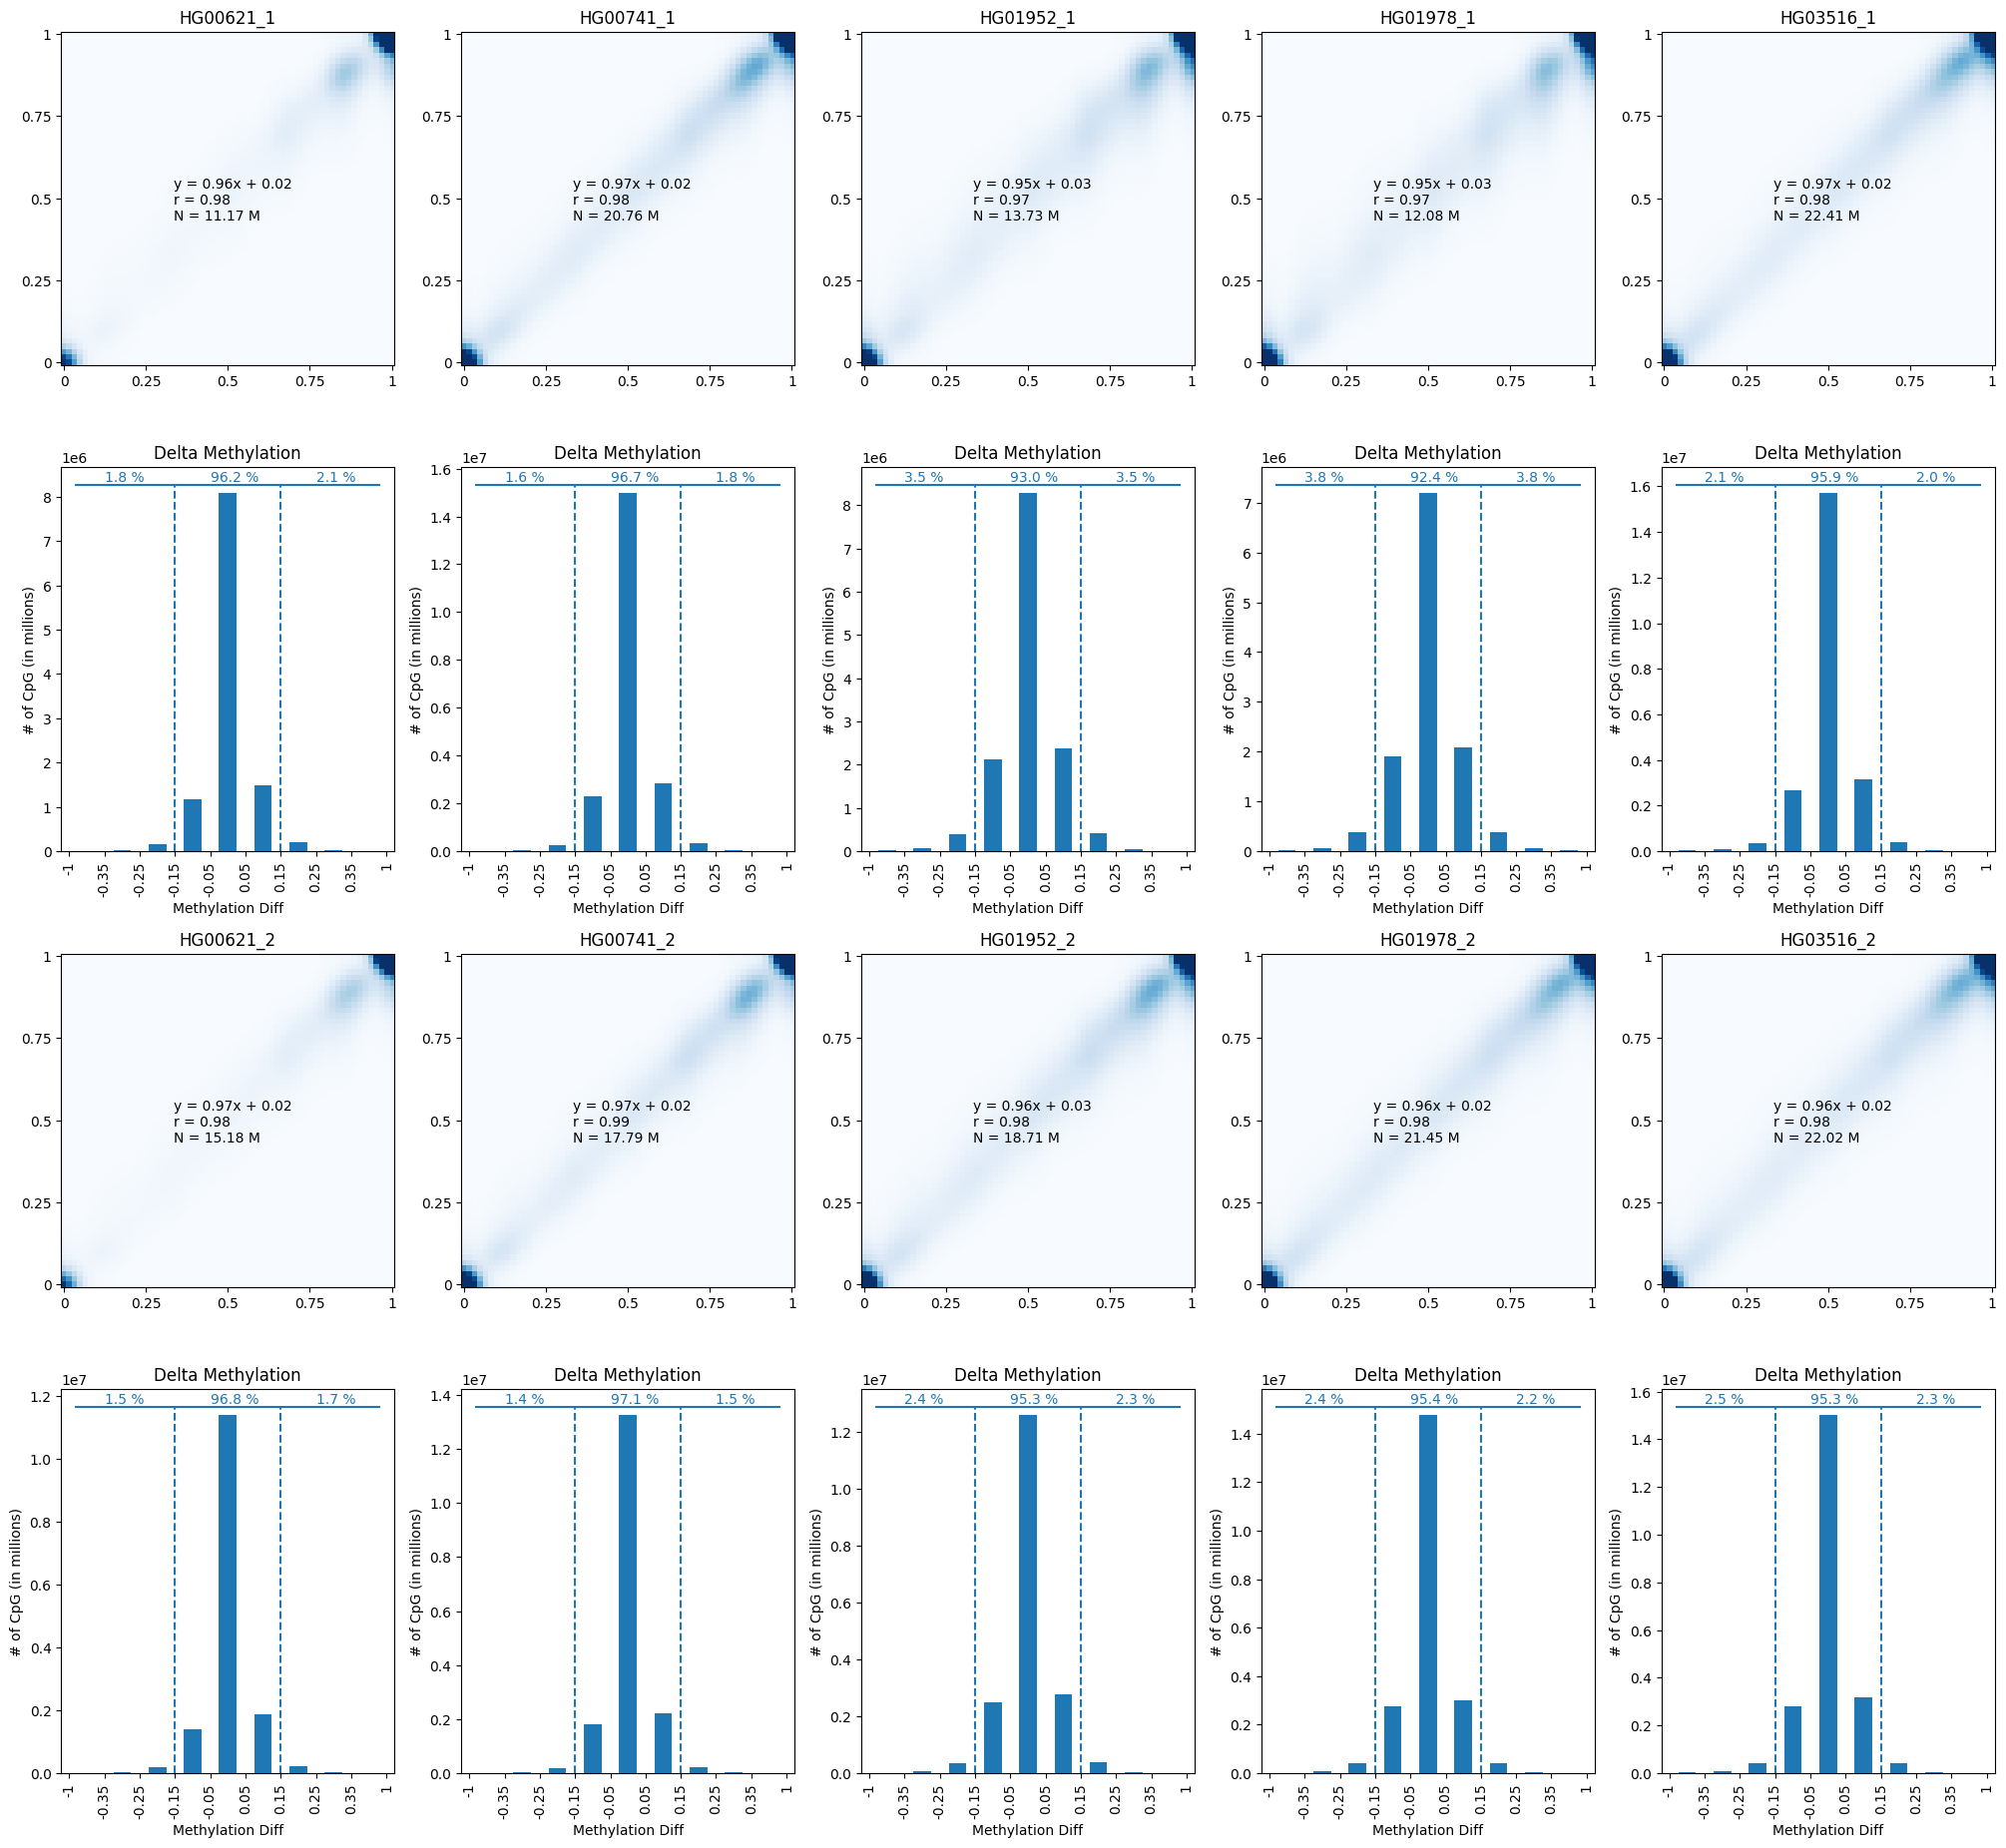

In [34]:
# Figure 4C

fig4C, axes4C = plt.subplots(4, 5, figsize=(25, 23))
for s in samples:
    for r in replicates:
        print(s, r)

        ml_delta = []
        bs_cpg_ml = []
        mg_cpg_ml = []


        bsd = bismark_cpg_data[s][r]
        mg2ld = methylgrapher_lifted_cytosine_data[s][r]

        found = 0

        for chrom in bsd:
            if chrom not in mg2ld:
                continue

            for pos in bsd[chrom]:
                pos = int(pos)

                bsd0 = bsd[chrom][pos]
                ml_bs = bsd0[0] / bsd0[1]
                if bsd0[1] <= min_cov:
                    continue

                mgd01 = mg2ld[chrom].get(pos, (0, 0))
                mgd02 = mg2ld[chrom].get(pos+1, (0, 0))

                mg_met = mgd01[0] + mgd02[0]
                mg_cov = mgd01[1] + mgd02[1]

                if mg_cov <= min_cov:
                    continue

                ml_mg = mg_met / mg_cov

                # print(ml_bs, f"{mg_met}/{mg_cov}", mgd01, mgd02)

                diff = ml_bs - ml_mg
                ml_delta.append(diff)

                bs_cpg_ml.append(ml_bs)
                mg_cpg_ml.append(ml_mg)

        k, b, r2 = linear_regression(bs_cpg_ml, mg_cpg_ml)
        r_pearson = pearson(bs_cpg_ml, mg_cpg_ml)






        hmd20 = density2d(bs_cpg_ml, mg_cpg_ml, bin=20)
        hmd30 = density2d(bs_cpg_ml, mg_cpg_ml, bin=30)
        hmd40 = density2d(bs_cpg_ml, mg_cpg_ml, bin=40)
        hmd50 = density2d(bs_cpg_ml, mg_cpg_ml, bin=50)
        hmd60 = density2d(bs_cpg_ml, mg_cpg_ml, bin=60)
        hmd70 = density2d(bs_cpg_ml, mg_cpg_ml, bin=70)
        hmd80 = density2d(bs_cpg_ml, mg_cpg_ml, bin=80)
        hmd90 = density2d(bs_cpg_ml, mg_cpg_ml, bin=90)
        hmd100 = density2d(bs_cpg_ml, mg_cpg_ml, bin=100)


        hmd = copy.deepcopy(hmd60)

        dim0 = hmd.shape[0]
        bcount = dim0-1
        bcount_half = int(bcount/2)

        newhmd = np.zeros(hmd.shape)
        for xo in range(dim0):
            for yo in range(dim0):
                xn = dim0-1 - yo
                yn = xo
                newhmd[xn, yn] = hmd[xo, yo]
        hmd = newhmd


        axes_xi = samples.index(s)
        axes_yi = replicates.index(r)
        if axes_yi == 1:
            axes_yi += 1

        ax1 = axes4C[axes_yi, axes_xi]
        ax2 = axes4C[axes_yi+1, axes_xi]

        ax1.set_xticks([0, 0.25*bcount, 0.5*bcount, 0.75*bcount, bcount], [0, 0.25, 0.5, 0.75, 1])
        ax1.set_yticks([bcount, 0.75*bcount, 0.5*bcount, 0.25*bcount, 0], [0, 0.25, 0.5, 0.75, 1])


        hmd_gb = gaussian_filter(hmd, sigma=2)
        im = ax1.imshow(hmd_gb, cmap="Blues", vmin=0, vmax=0.03) # , vmin=0, vmax=0.02


        ax1.text(20, 34, f"y = {k:0.2f}x + {b:0.2f}\nr = {r_pearson:0.2f}\nN = {len(bs_cpg_ml)/1e6:0.2f} M", fontsize=10, color="black")
        ax1.set_title(f"{s}_{r}")


        # ax1.colorbar(im, fraction=0.02)




        # seaborn.kdeplot(np.array(ml_delta), bw_method=0.1, ax=ax2)
        delta_x, delta_y = diff_bar_graph_data(ml_delta)
        ax2.bar(delta_x, delta_y, width=0.05)
        ax2.set_title(f"Delta Methylation")
        ax2.set_xlabel("Methylation Diff")
        ax2.set_ylabel("# of CpG (in millions)")
        
        y0 = max(delta_y) * 1.02
        ax2.plot([-0.43, 0.43], [y0, y0], color='#1f76b4',)
        ax2.plot([0.15, 0.15], [0, y0], linestyle='dashed', color='#1f76b4',)
        ax2.plot([-0.15, -0.15], [0, y0], linestyle='dashed', color='#1f76b4',)
    
        t = [-0.45, -0.35, -0.25, -0.15, -0.05, 0.05, 0.15, 0.25, 0.35, 0.45]
        tl = [-1, -0.35, -0.25, -0.15, -0.05, 0.05, 0.15, 0.25, 0.35, 1]
        ax2.set_xticks(t, tl, rotation='vertical')
    
        a = sum(delta_y[:3]) / sum(delta_y) * 100
        b = sum(delta_y[3:6]) / sum(delta_y) * 100
        c = sum(delta_y[6:]) / sum(delta_y) * 100
    
        ax2.text(-0.35, y0*1.01, f"{a:0.1f} %", fontsize=10, color="#1f76b4")
        ax2.text(-0.05, y0*1.01, f"{b:0.1f} %", fontsize=10, color="#1f76b4")
        ax2.text( 0.25, y0*1.01, f"{c:0.1f} %", fontsize=10, color="#1f76b4")

        fig4C.savefig(f"./figures/4C.pdf", bbox_inches="tight")

        assert len(bs_cpg_ml) == len(mg_cpg_ml)
        print(f"\tY= {k:0.4f}X + {b:0.4f}, R^2 = {r2:0.4f} Pearson = {r_pearson:0.4f} N={len(bs_cpg_ml)/1e6:0.1f}M")




In [ ]:
# Coverage comparison

fig4X, axes4X = plt.subplots(4, 5, figsize=(25, 20))
for s in samples:
    for r in replicates:
        print(s, r)

        ml_delta = []
        bs_cpg_cov = []
        mg_cpg_cov = []


        bsd = bismark_cpg_data[s][r]
        mg2ld = methylgrapher_lifted_cytosine_data[s][r]

        found = 0

        for chrom in bsd:
            if chrom not in mg2ld:
                continue

            for pos in bsd[chrom]:
                pos = int(pos)

                bsd0 = bsd[chrom][pos]
                bs_cov = bsd0[1]

                mgd01 = mg2ld[chrom].get(pos, (0, 0))
                mgd02 = mg2ld[chrom].get(pos+1, (0, 0))

                mg_cov = mgd01[1] + mgd02[1]

                if bs_cov > 30:
                    bs_cov = 30
                if mg_cov > 30:
                    mg_cov = 30

                diff = bs_cov - mg_cov
                ml_delta.append(diff)

                bs_cpg_cov.append(bs_cov)
                mg_cpg_cov.append(mg_cov)

        k, b, r2 = linear_regression(bs_cpg_cov, mg_cpg_cov)



        hmd30 = density2dInt(bs_cpg_cov, mg_cpg_cov)


        hmd = copy.deepcopy(hmd30)

        dim0 = hmd.shape[0]
        bcount = dim0-1
        bcount_half = int(bcount/2)

        newhmd = np.zeros(hmd.shape)
        for xo in range(dim0):
            for yo in range(dim0):
                xn = dim0-1 - yo
                yn = xo
                newhmd[xn, yn] = hmd[xo, yo]
        hmd = newhmd


        axes_xi = samples.index(s)
        axes_yi = replicates.index(r)
        if axes_yi == 1:
            axes_yi += 1

        ax1 = axes4X[axes_yi, axes_xi]
        ax2 = axes4X[axes_yi+1, axes_xi]


        hmd_gb = gaussian_filter(hmd, sigma=2)
        im = ax1.imshow(hmd_gb, cmap="Blues", vmin=0, vmax=0.2) # , vmin=0, vmax=0.02


        ax1.text(0.5, 0.2, f"y = {k:0.2f}x + {b:0.2f}\nR² = {r2:0.2f}\nN={len(bs_cpg_cov)/1e6:0.1f} M", fontsize=10, color="red")
        ax1.set_title(f"{s}_{r}")

        # ax1.colorbar(im, fraction=0.02)




        seaborn.kdeplot(np.array(ml_delta), bw_method=0.1, ax=ax2)
        fig4X.savefig(f"./figures/4X.coverage.pdf", bbox_inches="tight")

        assert len(bs_cpg_cov) == len(mg_cpg_cov)
        print(f"\tY= {k:0.4f}X + {b:0.4f}, R^2 = {r2:0.4f} N={len(bs_cpg_cov)/1e6:0.1f} M")




In [14]:
# PCA Plot

cpg_pca_data = "4D.PCA.1.tsv"





bismark_cpg_data = {}
methylgrapher_lifted_cytosine_data = {}


for s in samples:
    bismark_cpg_data[s] = {}
    methylgrapher_lifted_cytosine_data[s] = {}


    for r in replicates:
        print(s, r)


        bismark_cpg_data[s][r] = {}
        methylgrapher_lifted_cytosine_data[s][r] = {}

        mg2l_fp = f"/scratch/wzhang/projects/ggWGBS/data/methylgrapher_pan_lifted/{s}_{r}.cytosine.methylc"
        bs_fp = f"/scratch/wzhang/projects/ggWGBS/data/bismark_hg38/{s}_{r}.cpg.methylc"

        for l in open(bs_fp):
            l = l.strip().split("\t")
            chrom, start, end, context, ml, strand, cov = l

            start = int(start)
            met = int(round(float(ml) * int(cov)))
            cov = int(cov)

            if chrom not in bismark_cpg_data[s][r]:
                bismark_cpg_data[s][r][chrom] = {}

            bismark_cpg_data[s][r][chrom][start] = (met, cov)

        for l in open(mg2l_fp):
            l = l.strip().split("\t")
            chrom, start, end, context, ml, strand, cov = l

            start = int(start)
            met = int(round(float(ml) * int(cov)))
            cov = int(cov)

            if chrom not in methylgrapher_lifted_cytosine_data[s][r]:
                methylgrapher_lifted_cytosine_data[s][r][chrom] = {}

            methylgrapher_lifted_cytosine_data[s][r][chrom][start] = (met, cov)

cpg_pca_data_fh = open(cpg_pca_data, "w")
cpg_ref_fp = "/scratch/wzhang/ref/linear/hg38/bismark/cpg_sites.bed"
for l in open(cpg_ref_fp):
    l = l.strip().split("\t")
    chrom, start, end = l
    start = int(start) -1
    
    pass_cov = True

    bs_cpgs = []
    mg_cpgs = []

    for s in samples:
        for r in replicates:
            if chrom not in bismark_cpg_data[s][r] or chrom not in methylgrapher_lifted_cytosine_data[s][r]:
                pass_cov = False
                break
                
            met, cov = bismark_cpg_data[s][r][chrom].get(start, (0, 0))
            if cov <= min_cov:
                pass_cov = False
                break
            bs_cpgs.append(met/cov)


            m1, c1 = methylgrapher_lifted_cytosine_data[s][r][chrom].get(start, (0, 0))
            m2, c2 = methylgrapher_lifted_cytosine_data[s][r][chrom].get(start+1, (0, 0))
            met = m1 + m2
            cov = c1 + c2
            if cov <= min_cov:
                pass_cov = False
                break
            mg_cpgs.append(met/cov)


    if not pass_cov:
        continue



    line = [chrom, start, end] + bs_cpgs + mg_cpgs
    line_str = "\t".join(map(str, line)) + "\n"
    cpg_pca_data_fh.write(line_str)
    
cpg_pca_data_fh.close()






HG00621 1
HG00621 2
HG00741 1
HG00741 2
HG01952 1
HG01952 2
HG01978 1
HG01978 2
HG03516 1
HG03516 2


In [ ]:
# https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/hg38.chrom.sizes

genome_size_str = """chr1	248956422
chr2	242193529
chr3	198295559
chr4	190214555
chr5	181538259
chr6	170805979
chr7	159345973
chrX	156040895
chr8	145138636
chr9	138394717
chr11	135086622
chr10	133797422
chr12	133275309
chr13	114364328
chr14	107043718
chr15	101991189
chr16	90338345
chr17	83257441
chr18	80373285
chr20	64444167
chr19	58617616
chrY	57227415
chr22	50818468
chr21	46709983"""

genome_size = {}
for l in genome_size_str.split("\n"):
    l = l.strip().split("\t")
    genome_size[l[0]] = int(l[1])


genome_bins = {}
bin_size = 3000
for chrom in sorted(genome_size.keys(), key=lambda x: int(x[3:] if x[3:] != "X" and x[3:] != "Y" else "23" if x[3:] == "M" else "24")):
    size = genome_size[chrom]
    
    start, end = 0, bin_size
    
    while end < size:
        genome_bins[bin_id] = (chrom, start, end)
        start += bin_size
        end += bin_size
        
        bin_id = f"{chrom}_{start}"
    print(bin_id)
    

def get_bin_id(chrom, start):
    res = f"{chrom}_{start//bin_size*bin_size}"
    if res not in genome_bins:
        if len(chrom) > 5:
            print(chrom, start, None)
        return None
    return res


genome_bins_data = {}
for l in open(cpg_pca_data):
    l = l.strip().split("\t")
    
    chrom, start, end = l[:3]
    values = list(map(float, l[3:]))
    
    start = int(start)
    end = int(end)
    
    # print(chrom, start, end, len(values))
    
    bin_id = get_bin_id(chrom, start)
    if bin_id == None:
        continue
    
    if bin_id not in genome_bins_data:
        genome_bins_data[bin_id] = []
    
    genome_bins_data[bin_id].append(values)
    

In [15]:
# Use Per-CpG 


common_cpg_data = {}
for l in open(cpg_pca_data):
    l = l.strip().split("\t")
    
    chrom, start, end = l[:3]
    values = list(map(float, l[3:]))
    
    ave = sum(values) / len(values)
    all_the_same = True
    for v in values:
        if abs(v - ave) > 0.00001:
            all_the_same = False
    if all_the_same:
        # print(chrom, start, "all the same, ", values)
        continue
    
    cpg_id = f"{chrom}_{start}"
    common_cpg_data[cpg_id] = values

cpg_ids = list(common_cpg_data.keys())
    


bin_pca_data_fh = open("4D.PCA.2.CpG.tsv", "w")
i = 0
for m in ["Bismark", "methylGrapher"]:
    for s in samples:
        for r in replicates:
            line = [s, r, m]
            
            for cpg_id in cpg_ids:
                line.append(common_cpg_data[cpg_id][i])
            
            line_str = "\t".join(list(map(str, line))) + "\n"
            bin_pca_data_fh.write(line_str)
            
            
            i += 1
bin_pca_data_fh.close()



In [ ]:
# Use Binned genome
bin_pca_data = "4D.PCA.2.tsv"

genome_bins_data_averaged = {}
for bin_id in genome_bins_data:
    
    
    sum_bin_ml = [0] * 20
    cpg_count = len(genome_bins_data[bin_id])
    
    for each_cpg in genome_bins_data[bin_id]:
        
        for i in range(20):
            sum_bin_ml[i] += each_cpg[i]
    
    for i in range(20):
        sum_bin_ml[i] /= cpg_count
    
    if cpg_count < 5:
        pass
        # print(bin_id, f"cpg count ({cpg_count}) < 10")
        #continue
    
    ave = sum(sum_bin_ml) / 20
    all_the_same = True
    for i in range(20):
        if abs(sum_bin_ml[i] - ave) > 0.0001:
            all_the_same = False
    if all_the_same:
        print(bin_id, f"all the same, {sum_bin_ml}")
        continue
    
    
    genome_bins_data_averaged[bin_id] = sum_bin_ml


bin_ids = list(genome_bins_data_averaged.keys())


bin_pca_data_fh = open(bin_pca_data, "w")
i = 0
for m in ["Bismark", "methylGrapher"]:
    for s in samples:
        for r in replicates:
            line = [s, r, m]
            
            for bin_id in bin_ids:
                line.append(genome_bins_data_averaged[bin_id][i])
            
            line_str = "\t".join(list(map(str, line))) + "\n"
            bin_pca_data_fh.write(line_str)
            
            
            i += 1
bin_pca_data_fh.close()
            



    

In [18]:




df = pandas.read_csv("4D.PCA.2.CpG.tsv", sep="\t", header=None)
# print(df.shape)
# print(df.head())


labels = {}

for i in range(20):
    s = df.iloc[i, 0]
    r = df.iloc[i, 1]
    m = df.iloc[i, 2]
    labels[i] = f"{s}_{r}_{m}"

# print()

df2 = df.iloc[:, 3:]
# print(df2.shape)






pca = PCA(n_components=2)

principalComponents = pca.fit_transform(df2)


# print(principalComponents.shape)
# print(principalComponents)


for i in range(principalComponents.shape[0]):
    label = labels[i]
    pc1 = principalComponents[i, 0]
    pc2 = principalComponents[i, 1]
    
    
    # print(label, pc1, pc2)
    





(20, 2771344)


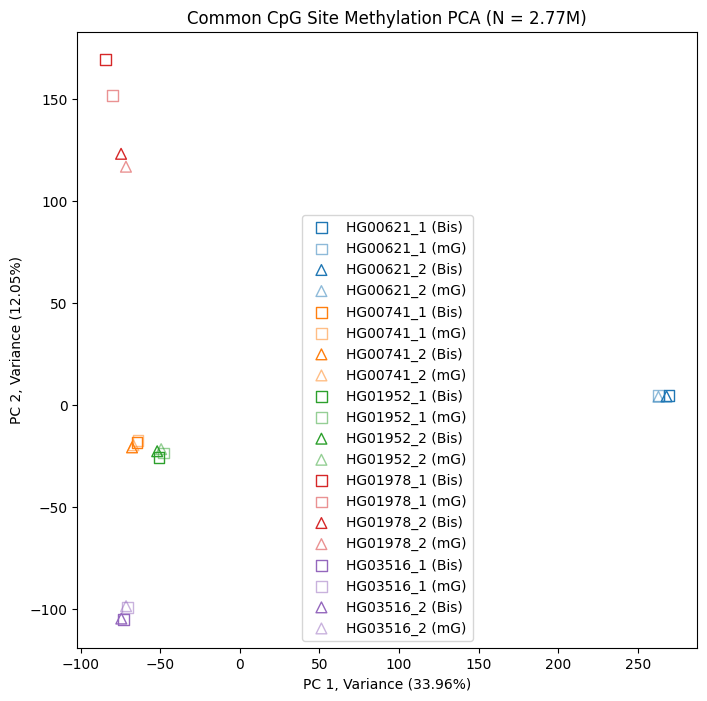

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))
# ax.scatter(principalComponents[:, 0], principalComponents[:, 1])

sample_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
# replicate_marker = ["." , "," , "o" , "v" , "^" , "<", ">"]

markers = ["," , "^" ]

pca_data = {}
for i in range(principalComponents.shape[0]):
    label = labels[i]
    s, r, m = label.split("_")
    if s not in pca_data:
        pca_data[s] = {}
    if r not in pca_data[s]:
        pca_data[s][r] = {}
    pca_data[s][r][m] = (principalComponents[i, 0], principalComponents[i, 1])


for s in sorted(pca_data.keys()):
    for r in sorted(pca_data[s].keys()):
        for m in pca_data[s][r]:
            
            new_m = "Bis"
            if m == "methylGrapher":
                new_m = "mG"
            new_label = f"{s}_{r} ({new_m})"
            pc1 = pca_data[s][r][m][0]
            pc2 = pca_data[s][r][m][1]
            
            color = sample_colors[samples.index(s)]
            marker = markers[replicates.index(int(r))]
            alpha = 1
            
            if m != "Bismark":
                # marker = markers[replicates.index(int(r))+2]
                alpha = 0.5
            
            ax.scatter([pc1], [pc2], color=color, label=new_label, marker=marker, alpha=alpha, s=60, facecolors='none')
            
            ax.set_xlabel(f'PC 1, Variance ({round(pca.explained_variance_ratio_[0]*100, 2)}%)')
            ax.set_ylabel(f'PC 2, Variance ({round(pca.explained_variance_ratio_[1]*100, 2)}%)')
            ax.set_title(f'Common CpG Site Methylation PCA (N = {df.shape[1]/1e6:0.2f}M)')

ax.legend()
plt.savefig("./figures/4D.PCA.CpG.pdf", bbox_inches='tight')


In [39]:
# Figure 5C

#bismark_cpg_data = {}
#methylgrapher_cytosine_data = {}

pan_cpg_list = []
pan_cpg_list_fp = f"/scratch/wzhang/projects/ggWGBS/cpg_categorization/pan_v1_cpg.tsv"
hg38_loci_regex = re.compile(r"hg38\((.*):(\d*)\)")


seen = set()
with open(pan_cpg_list_fp) as fh:
    for l in fh:
        l = l.strip().split("\t")
        cpgid, segID1, seg_pos1, segID2, seg_pos2, cpg_type = l
        seg_pos1 = int(seg_pos1)
        seg_pos2 = int(seg_pos2)

        info = tuple([cpg_type])
        if cpg_type.startswith("hg38"):
            chrom, start = hg38_loci_regex.findall(cpg_type)[0]
            start = int(start)
            info = ("hg38", chrom, start)
            # print(cpg_type, chrom, start)
            # break

        xxx = info[0]
        if xxx not in seen:
            seen.add(xxx)
            print(xxx, l)

        c = (segID1, seg_pos1, segID2, seg_pos2, info)
        pan_cpg_list.append(c)
        



SV ['C0', '28', '118', '28', '119', 'SV']
hg38 ['C17723', '9826', '10468', '9826', '10469', 'hg38(chr1:10468)']
SNV ['E0', '29', '8', '5850202', '0', 'SNV']


In [47]:

cpg_unique_data = {}

for s in samples:
    cpg_unique_data[s] = {}

    for r in replicates:
        print(s, r)
        bs_cpg = bismark_cpg_data[s][r]
        mg_cytosine = methylgrapher_cytosine_data[s][r]

        total_bs = 0
        for chrom in bs_cpg.keys():
            total_bs += len(bs_cpg[chrom])

        common, bss = 0, 0
        mg_counts = [0, 0, 0]
        for cpg in pan_cpg_list:
            segID1, seg_pos1, segID2, seg_pos2, info = cpg

            mge, bse = False, False
            if segID1 in mg_cytosine:
                if seg_pos1 in mg_cytosine[segID1]:
                    mge = True
            if segID2 in mg_cytosine:
                if seg_pos2 in mg_cytosine[segID2]:
                    mge = True

            cpg_type = info[0]
            if cpg_type == "hg38":
                chrom = info[1]
                start = info[2]
                
                if chrom in bs_cpg:
                    if start in bs_cpg[chrom]:
                        bse = True

            if mge and bse:
                common += 1
            elif bse:
                bss += 1
            elif mge:
                i = ["hg38", "SNV", "SV"].index(cpg_type)
                #if i == 0 and len(chrom) > 5:
                #     i = 3
                mg_counts[i] += 1
                
        cpg_unique_data[s][r] = [bss, common] + mg_counts


        
        print(common)
        print(mg_counts, sum(mg_counts))
        print(bss)
        print()



HG00621 1
26247010
[835622, 1517266, 597134] 2950022
936465

HG00621 2
26578366
[588852, 1555654, 601501] 2746007
978903

HG00741 1
26906175
[329521, 1595666, 615210] 2540397
1014459

HG00741 2
26780293
[375023, 1558427, 564566] 2498016
1009743

HG01952 1
26355245
[929350, 1619828, 704637] 3253815
917531

HG01952 2
26798211
[511695, 1593348, 670233] 2775276
987139

HG01978 1
26099044
[1103437, 1609682, 686226] 3399345
885702

HG01978 2
26846518
[436718, 1623052, 689585] 2749355
995363

HG03516 1
26955252
[365213, 1657400, 747698] 2770311
974167

HG03516 2
26913426
[418049, 1668855, 771478] 2858382
950486



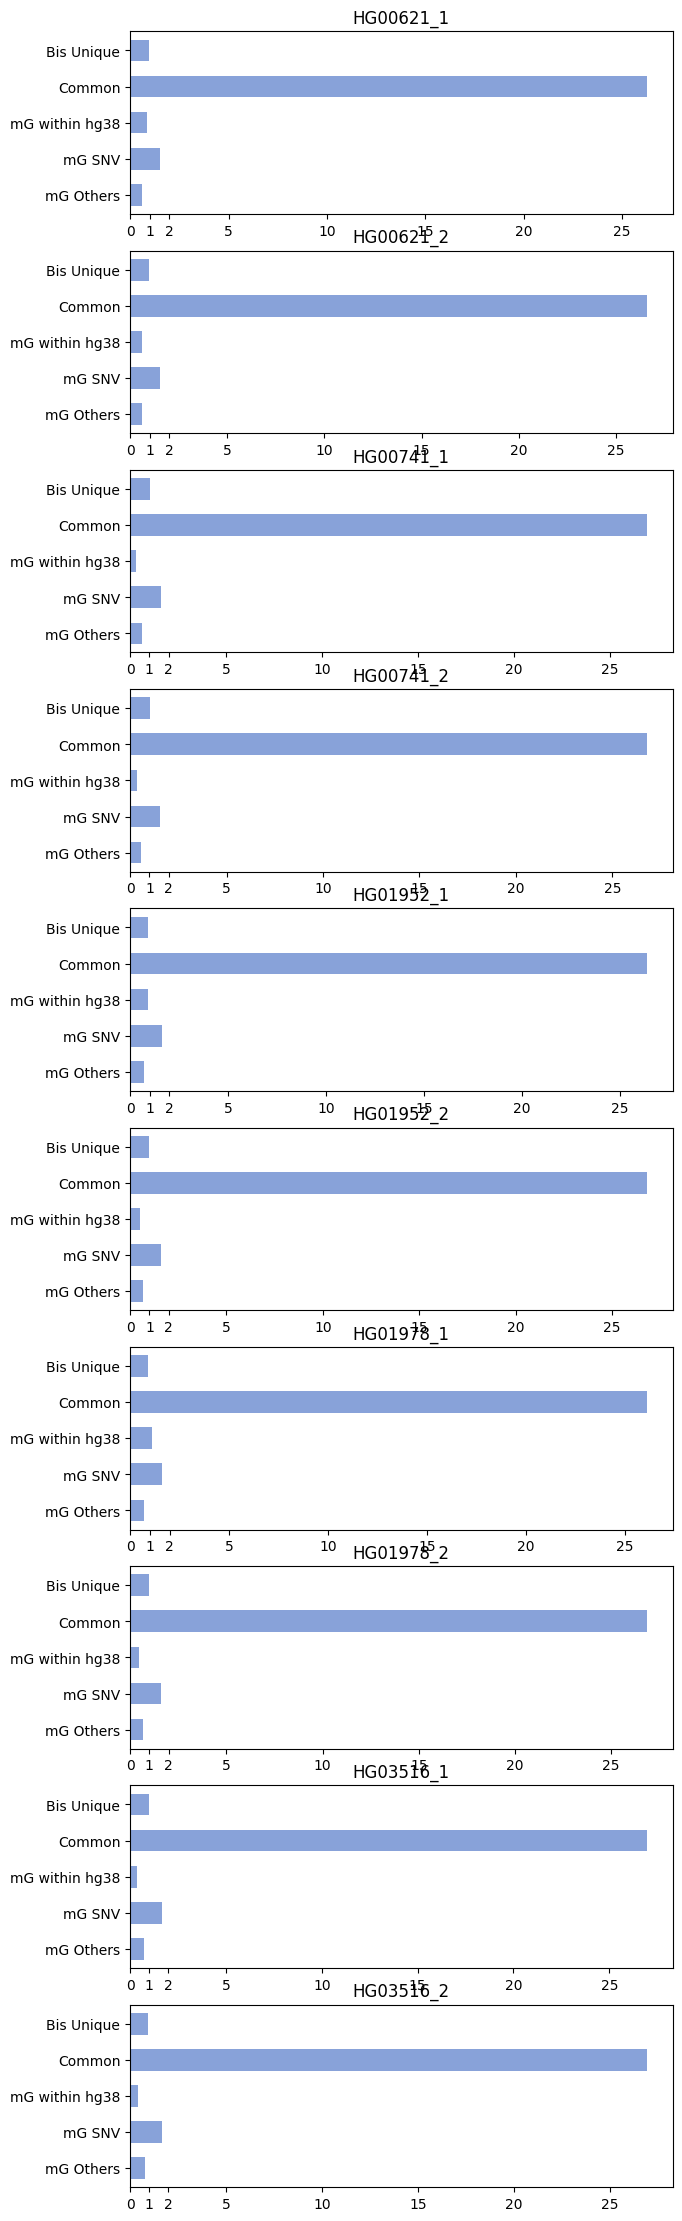

In [53]:

fig5A, axes5A = plt.subplots(10, 1, figsize=(7, 28))

axes_i = 0
for s in samples:

    for r in replicates:
        d = cpg_unique_data[s][r][:]

        bar_x = ["Bis Unique", "Common", "mG within hg38", "mG SNV", "mG Others"]

        bar_x = list(reversed(bar_x))
        d = list(reversed(d))
        
        axes5A[axes_i].barh(bar_x, d, color="#88a2d9", height=0.6)

        axes5A[axes_i].set_title(f"{s}_{r}")
        # axes5A[axes_i].legend()

        xticks = [0, 1e6, 2e6]
        xticks_label = [0, 1, 2]
        for i in range(5):
            m = 0.5*1e7*(i+1)
            label = str(round(5*(i+1)))
            
            xticks.append(m)
            xticks_label.append(label)
        
        axes5A[axes_i].set_xticks(xticks, xticks_label)

        axes_i += 1

fig5A.savefig(f"./figures/5A.pdf", bbox_inches='tight')

